In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

### GSEA on TCGA dataset using T-Tests and Wilcoxon

In [155]:
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

def perform_wilcoxon_test(X, y, group1, group2):

    X_group1 = X[y == group1]
    X_group2 = X[y == group2]
    combined_metrics = []
    p_values = []
    log_fold_changes = []

    for feature in X.columns:
        group1_feature = X_group1[feature].dropna()
        group2_feature = X_group2[feature].dropna()

        if len(group1_feature) > 0 and len(group2_feature) > 0:
            _, p_value = mannwhitneyu(group1_feature, group2_feature, alternative='two-sided')
            
            mean_group1 = group1_feature.mean()
            mean_group2 = group2_feature.mean()
            
            # Calculate log fold change if means are non-zero
            if mean_group1 > 0 and mean_group2 > 0:
                log_fc = np.log2(mean_group1 / mean_group2)
            else:
                log_fc = np.nan
            
            # Compute the combined metric: -log10(p-value) * sign(log2FC)
            if not np.isnan(log_fc):
                combined_metric = -np.log10(p_value) * np.sign(log_fc)
            else:
                combined_metric = np.nan
        else:
            p_value, log_fc, combined_metric = np.nan, np.nan, np.nan

        p_values.append(p_value)
        log_fold_changes.append(log_fc)
        combined_metrics.append(combined_metric)

    results = pd.DataFrame({
        'Feature': X.columns,
        'P-Value': p_values,
        'Log2FC': log_fold_changes,
        'Combined Metric': combined_metrics,
    }).dropna().sort_values(by='Combined Metric', ascending=False) 

    return results



In [156]:

comparisons = [
    ('Stage I','Normal'),
    ('Stage II','Normal'),
    ('Stage I', 'Stage II')
 
]


results = {}

for group1, group2 in comparisons:
    print(f"Processing comparison: {group1} vs. {group2}")
    filtered_data = tcga[tcga['combined_stage'].isin([group1, group2])]
    X_filtered = filtered_data.iloc[:,:20530]
    X_new = X_filtered.loc[:, (X_filtered != X_filtered.iloc[0]).any()]
    y_filtered = filtered_data['combined_stage']
    wil_results =perform_wilcoxon_test(X_new, y_filtered, group1, group2)

    results[f'{group1}_vs_{group2}'] = {
        'T-Test Results': wil_results
    }
stage1_vs_normal_results = results['Stage I_vs_Normal']
t_test_df = stage1_vs_normal_results['T-Test Results']

Processing comparison: Stage I vs. Normal


KeyboardInterrupt: 

In [39]:
t_test_df

,Feature,P-Value,Log2FC,Combined Metric
12735,MMP11,1.449849e-46,0.932911,45.838677
2774,COL10A1,2.765840e-46,1.497477,45.558173
12571,IBSP,1.409568e-44,3.921392,43.850914
12421,SLC35A2,1.405612e-43,0.176252,42.852135
14381,CKS2,2.245191e-43,0.422745,42.648747
...,...,...,...,...
12882,LMOD1,1.704229e-46,-0.434764,-45.768472
2722,SDPR,1.571964e-46,-0.715892,-45.803557
4279,FIGF,1.477493e-46,-1.520883,-45.830474
17662,SCN4B,1.114609e-46,-0.504444,-45.952877


In [40]:
stage2_vs_normal_results = results['Stage II_vs_Normal']

In [41]:
stage2_vs_normal_results['T-Test Results']

,Feature,P-Value,Log2FC,Combined Metric
12797,MMP11,1.720835e-62,0.910608,61.764261
10785,NEK2,1.344425e-61,1.105465,60.871463
7194,UBE2T,6.536247e-61,0.680253,60.184672
12378,PKMYT1,2.156896e-60,1.173982,59.666171
14451,CKS2,2.585856e-60,0.465410,59.587396
...,...,...,...,...
2736,SDPR,3.580490e-63,-0.811582,-62.446058
4301,FIGF,3.236021e-63,-1.653288,-62.489989
7978,CA4,4.027567e-64,-2.601378,-63.394957
5447,LOC572558,3.046814e-64,-2.699219,-63.516154


In [42]:
stage1_vs_stage2_results = results['Stage I_vs_Stage II']

In [43]:
stage1_vs_stage2_results['T-Test Results']

,Feature,P-Value,Log2FC,Combined Metric
18736,CYBRD1,1.907916e-07,0.077278,6.719441
18716,DARC,2.239179e-07,0.221827,6.649911
8750,RASL11A,3.902026e-07,0.117330,6.408710
7570,PHYHD1,6.249509e-07,0.189200,6.204154
6836,FCER1A,7.535250e-07,0.234260,6.122902
...,...,...,...,...
4645,SGOL1,7.863783e-07,-0.137525,-6.104368
15288,TTK,7.633979e-07,-0.102964,-6.117249
2151,FAM72B,4.476766e-07,-0.120717,-6.349036
16631,PBK,2.058222e-07,-0.106108,-6.686508


##### Thresholding

In [44]:
def thresh(df):
    logfc_threshold = 0.5
    pval_threshold = 0.05
    
    # Filter genes
    filtered_genes = df[
        (abs(df['Log2FC']) >= logfc_threshold) &  # Magnitude of log fold change
        (df['P-Value'] <= pval_threshold)       # Significance threshold
    ]
    return filtered_genes

In [45]:
stage1_vs_normal=thresh(stage1_vs_normal_results['T-Test Results'])

In [46]:
stage1_vs_normal

,Feature,P-Value,Log2FC,Combined Metric
12735,MMP11,1.449849e-46,0.932911,45.838677
2774,COL10A1,2.765840e-46,1.497477,45.558173
12571,IBSP,1.409568e-44,3.921392,43.850914
10727,NEK2,2.523604e-43,1.021532,42.597979
10793,BMP8A,9.446203e-43,0.554312,42.024743
...,...,...,...,...
18698,MAMDC2,6.699947e-46,-0.671755,-45.173929
2722,SDPR,1.571964e-46,-0.715892,-45.803557
4279,FIGF,1.477493e-46,-1.520883,-45.830474
17662,SCN4B,1.114609e-46,-0.504444,-45.952877


In [47]:
stage2_vs_normal=thresh(stage2_vs_normal_results['T-Test Results'])

In [48]:
stage2_vs_normal

,Feature,P-Value,Log2FC,Combined Metric
12797,MMP11,1.720835e-62,0.910608,61.764261
10785,NEK2,1.344425e-61,1.105465,60.871463
7194,UBE2T,6.536247e-61,0.680253,60.184672
12378,PKMYT1,2.156896e-60,1.173982,59.666171
1041,ASF1B,4.971181e-60,0.618314,59.303540
...,...,...,...,...
2736,SDPR,3.580490e-63,-0.811582,-62.446058
4301,FIGF,3.236021e-63,-1.653288,-62.489989
7978,CA4,4.027567e-64,-2.601378,-63.394957
5447,LOC572558,3.046814e-64,-2.699219,-63.516154


In [49]:
stage1_vs_stage2=thresh(stage1_vs_stage2_results['T-Test Results'])

In [50]:
stage1_vs_stage2

,Feature,P-Value,Log2FC,Combined Metric
2249,KLK3,0.000034,0.549925,4.468933
3935,UCP1,0.000069,0.601934,4.159818
7978,CA4,0.000123,0.508433,3.908654
10801,NPY2R,0.000149,0.551874,3.827208
8134,SNORA9,0.000299,1.163698,3.524321
...,...,...,...,...
15410,MAGEA3,0.000260,-1.062847,-3.584355
572,CPLX3,0.000259,-0.508310,-3.586670
343,RTBDN,0.000248,-0.503079,-3.604872
6401,LHX1,0.000241,-1.100046,-3.617387


##### GSEA

In [67]:
gsea_1_2= stage1_vs_stage2_results[['Feature','Combined Metric']]

In [69]:
gsea_1_2 = gsea_1_2.sort_values(by='Combined Metric', ascending=False)

In [70]:
gsea_1_2=gsea_1_2.set_index("Feature")

In [71]:
gsea_1_2

,Combined Metric
Feature,
KLK3,4.468933
UCP1,4.159818
CA4,3.908654
NPY2R,3.827208
SNORA9,3.524321
...,...
MAGEA3,-3.584355
CPLX3,-3.586670
RTBDN,-3.604872


In [72]:
gsea_1_nor= stage1_vs_normal_results[['Feature','Combined Metric']]

In [73]:
gsea_1_nor= gsea_1_nor.sort_values(by='Combined Metric', ascending=False)

In [74]:
gsea_1_nor=gsea_1_nor.set_index("Feature")

In [75]:
gsea_1_nor.head(50)

,Combined Metric
Feature,
MMP11,45.838677
COL10A1,45.558173
IBSP,43.850914
NEK2,42.597979
BMP8A,42.024743
KIAA0101,41.923984
HSD17B6,41.898816
PKMYT1,41.840159
UBE2T,41.563975


In [76]:
gsea_2_nor= stage2_vs_normal_results[['Feature','Combined Metric']]

In [77]:
gsea_2_nor= gsea_2_nor.sort_values(by='Combined Metric', ascending=False)

In [78]:
gsea_2_nor=gsea_2_nor.set_index("Feature")

In [79]:
gsea_2_nor.head(50)

,Combined Metric
Feature,
MMP11,61.764261
NEK2,60.871463
UBE2T,60.184672
PKMYT1,59.666171
ASF1B,59.303540
KIAA0101,59.190874
KIF4A,59.170400
COL10A1,59.129465
CDK1,58.952244


In [80]:
gsea_1_nor.to_csv("gsea_1_nor.rnk", header=False, sep='\t')

In [47]:
gsea_2_nor.to_csv("gsea_2_nor.rnk", header=False, sep='\t')

In [48]:
gsea_1_2.to_csv("gsea_1_2.rnk", header=False, sep='\t')

#### Stage 1 samples vs solid normal samples: Positively enriched pathway

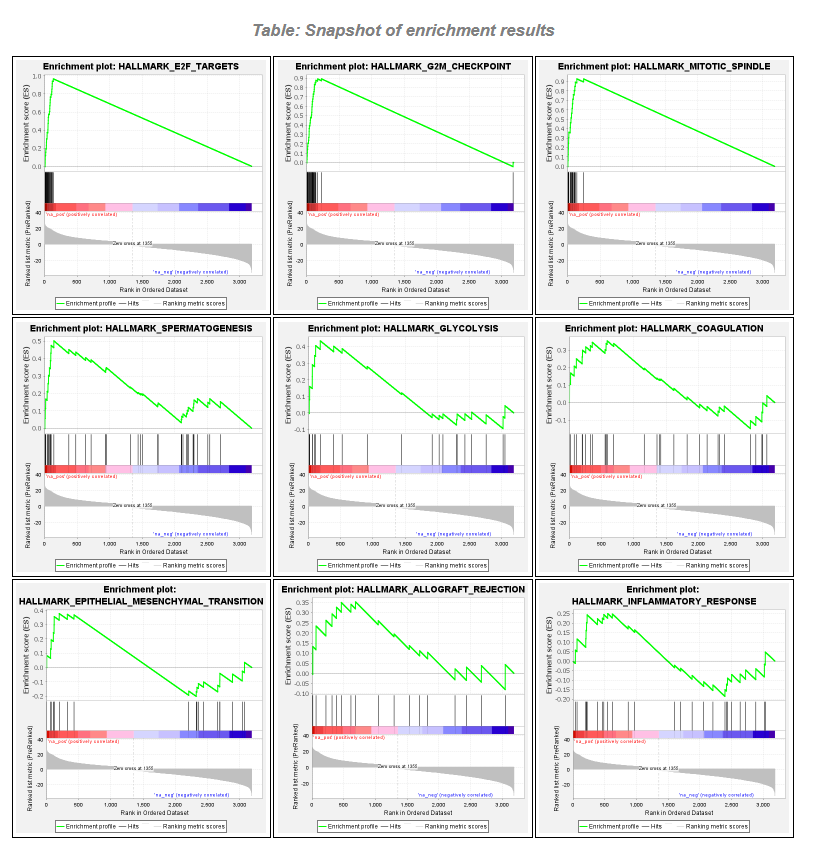

#### Potential biomarkers for early stage (coagulation pathway)

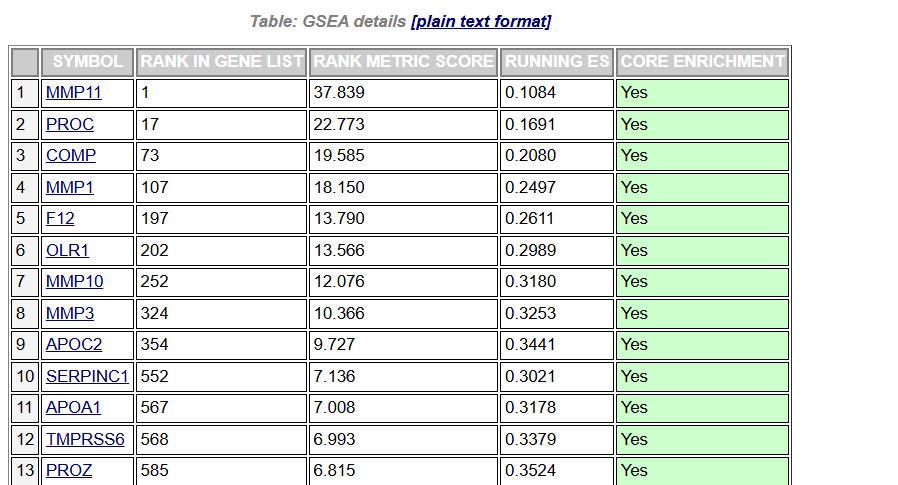

#### Stage 1 samples vs solid normal samples: Negatively enriched pathways

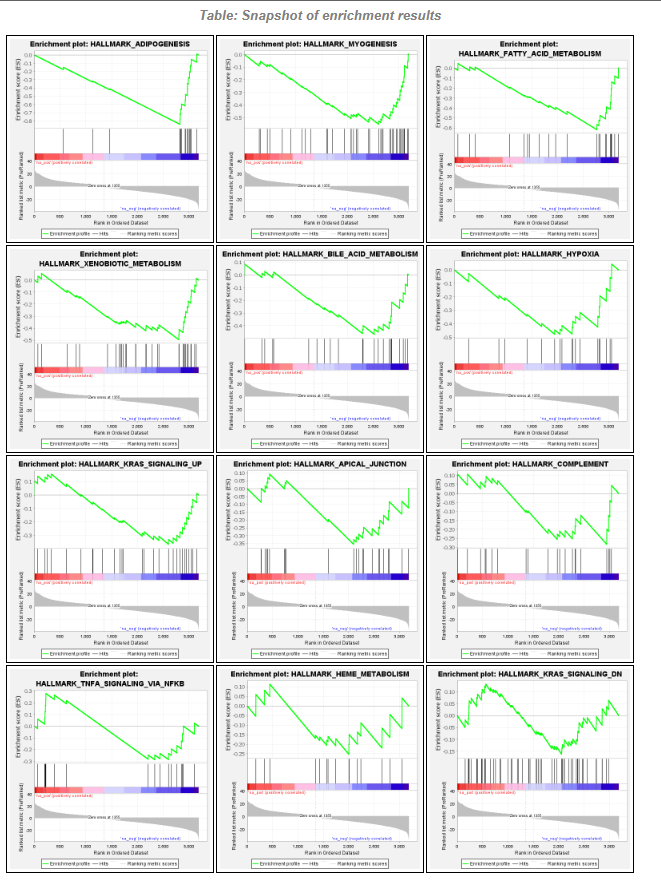

### Classical ML models for feature selection

In [115]:
for x in tcga.iloc[:, 20531:].columns:
    print(tcga[x].value_counts())
    print("----------------------------------")

cancer type abbreviation
0    1215
Name: count, dtype: int64
----------------------------------
age_at_initial_pathologic_diagnosis
62.000000    55
63.000000    42
56.000000    38
58.000000    36
50.000000    36
             ..
58.242998     1
86.000000     1
33.000000     1
28.000000     1
27.000000     1
Name: count, Length: 66, dtype: int64
----------------------------------
gender
0    1202
1      13
Name: count, dtype: int64
----------------------------------
race
0    867
1    189
2     93
3     62
4      3
5      1
Name: count, dtype: int64
----------------------------------
ajcc_pathologic_tumor_stage
2     359
0     260
4     155
14    113
8      90
9      86
1      67
3      27
6      20
7      13
5       6
10      6
11      6
13      5
12      2
Name: count, dtype: int64
----------------------------------
histological_type
0    882
1    210
2     47
4     39
3     18
7      9
6      8
5      1
8      1
Name: count, dtype: int64
----------------------------------
initial_path

In [157]:
tcga= tcga.drop(columns=["ajcc_pathologic_tumor_stage"])

#### Method 1: Binary target

In [159]:
new_df= tcga[tcga["combined_stage"].isin(["Stage I", "Normal"])]

In [160]:
new_df

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,sample_type_id,sample_type,_primary_disease,combined_stage
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-A8-A08A-01,9.8786,0.4455,0.0000,11.9033,10.9511,9.9164,12.6493,2.2073,0.0000,6.0784,...,30.0,0.000000,30.000000,0.0,30.0,0,1.0,1,0,Stage I
TCGA-E2-A15O-01,9.3760,0.8672,0.0000,12.4611,10.7180,9.0355,13.4042,2.7589,0.4978,3.6482,...,1545.0,1.000000,1210.000000,1.0,1210.0,0,1.0,1,0,Stage I
TCGA-BH-A1FG-01,10.2439,1.6713,0.0000,12.0515,11.3830,11.3950,12.5189,3.9604,0.4481,5.3207,...,3736.0,0.087669,1172.677917,0.0,3736.0,0,1.0,1,0,Stage I
TCGA-BH-A8FY-01,9.8860,2.5831,0.0000,12.0487,10.6782,9.7698,12.6934,4.8166,0.0000,4.8448,...,295.0,0.000000,295.000000,0.0,295.0,0,1.0,1,0,Stage I
TCGA-E9-A54X-01,8.3141,1.3159,0.0000,12.0865,11.8970,10.5531,13.0418,2.5766,0.0000,4.5450,...,727.0,0.000000,727.000000,0.0,727.0,0,1.0,1,0,Stage I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A0D9-11,9.5692,9.3537,0.0000,11.9178,11.9225,10.8396,12.6587,6.2643,0.0000,3.8317,...,1139.0,0.000000,1139.000000,0.0,1139.0,0,11.0,2,0,Normal
TCGA-BH-A1FN-11,9.2609,7.6353,0.0000,11.7187,11.5151,11.1673,12.6550,5.3089,0.6569,4.7677,...,2192.0,0.087669,1172.677917,1.0,2192.0,0,11.0,2,0,Normal
TCGA-BH-A0HA-11,10.6813,7.1427,0.0000,11.5149,11.1492,10.8266,12.7275,4.5171,0.4911,3.4239,...,1611.0,0.000000,1611.000000,0.0,1611.0,0,11.0,2,0,Normal


In [161]:
new_df['combined_stage'] = new_df['combined_stage'].map({'Normal': 0, 'Stage I': 1})

C:\Users\Neermita Bhattachary\AppData\Local\Temp\ipykernel_6204\3196489016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['combined_stage'] = new_df['combined_stage'].map({'Normal': 0, 'Stage I': 1})


In [162]:
X= new_df.iloc[:, :20530]

In [163]:
X

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-A8-A08A-01,9.8786,0.4455,0.0000,11.9033,10.9511,9.9164,12.6493,2.2073,0.0000,6.0784,...,0.0000,1.4901,4.2272,0.0000,8.7631,11.9386,7.9251,12.0569,4.6577,9.8081
TCGA-E2-A15O-01,9.3760,0.8672,0.0000,12.4611,10.7180,9.0355,13.4042,2.7589,0.4978,3.6482,...,0.4978,10.7341,3.6000,3.1423,9.9240,11.0286,7.3262,10.5413,6.3534,10.2369
TCGA-BH-A1FG-01,10.2439,1.6713,0.0000,12.0515,11.3830,11.3950,12.5189,3.9604,0.4481,5.3207,...,0.0000,0.4481,3.5759,0.0000,8.8127,10.7197,7.5671,11.4650,5.6168,11.1774
TCGA-BH-A8FY-01,9.8860,2.5831,0.0000,12.0487,10.6782,9.7698,12.6934,4.8166,0.0000,4.8448,...,0.6366,9.1396,4.5694,0.0000,9.2343,11.0727,8.1521,12.3786,7.1260,10.2285
TCGA-E9-A54X-01,8.3141,1.3159,0.0000,12.0865,11.8970,10.5531,13.0418,2.5766,0.0000,4.5450,...,0.0000,3.8486,0.5816,0.0000,9.3287,8.8464,5.4164,11.1384,1.8002,11.2900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A0D9-11,9.5692,9.3537,0.0000,11.9178,11.9225,10.8396,12.6587,6.2643,0.0000,3.8317,...,1.3377,7.8778,4.0246,0.0000,9.5979,15.6531,9.4835,11.3607,9.5624,9.6880
TCGA-BH-A1FN-11,9.2609,7.6353,0.0000,11.7187,11.5151,11.1673,12.6550,5.3089,0.6569,4.7677,...,1.4490,3.9995,5.1771,0.0000,9.8558,13.3340,9.7836,11.1799,10.5705,9.7115
TCGA-BH-A0HA-11,10.6813,7.1427,0.0000,11.5149,11.1492,10.8266,12.7275,4.5171,0.4911,3.4239,...,1.7795,3.7187,3.7187,0.0000,9.6036,13.2154,7.0921,11.0640,7.4137,9.2804


In [214]:
y=new_df["combined_stage"]

In [215]:
y

samples
TCGA-A8-A08A-01    1
TCGA-E2-A15O-01    1
TCGA-BH-A1FG-01    1
TCGA-BH-A8FY-01    1
TCGA-E9-A54X-01    1
                  ..
TCGA-A7-A0D9-11    0
TCGA-BH-A1FN-11    0
TCGA-BH-A0HA-11    0
TCGA-BH-A1FE-11    0
TCGA-BH-A0DG-11    0
Name: combined_stage, Length: 295, dtype: int64

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [141]:
X_train

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-E2-A1IJ-01,9.8606,1.5493,0.0000,12.0093,11.1076,10.4773,12.3719,4.6671,0.0000,6.1102,...,0.7157,0.7157,4.7382,0.0000,9.3535,13.4343,8.9472,11.0379,8.6317,9.7455
TCGA-BH-A208-11,10.2535,6.4730,0.0000,11.4722,11.2954,10.9711,12.3574,3.8494,0.7126,4.0295,...,1.9540,4.1118,3.4881,0.0000,9.5623,13.3931,7.0121,10.9259,7.1835,9.7339
TCGA-GI-A2C8-11,11.4655,7.1927,2.2077,13.3639,12.3311,10.6249,12.1582,6.1352,0.0000,3.7452,...,1.0244,3.2913,3.0425,0.0000,8.1062,13.0824,9.1009,11.5277,7.3008,9.5261
TCGA-BH-A18M-11,9.7540,8.7564,2.1782,11.7744,11.5930,10.5854,12.5516,5.5359,0.9118,4.8014,...,1.8656,6.3746,3.6892,0.0000,9.7250,14.1819,9.7825,11.0766,9.0302,9.2684
TCGA-GM-A2DO-01,10.1205,3.3013,1.9829,11.7921,10.2191,10.2923,12.5172,5.5012,0.9886,3.8855,...,0.0000,0.9886,5.9547,0.0000,8.3259,10.7033,7.1671,12.3833,7.5164,10.4417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A0HB-01,9.8510,1.5425,0.0000,12.4752,11.3772,10.6458,12.6051,3.6955,0.9683,5.6095,...,0.0000,5.7314,4.3982,0.0000,8.0048,11.9629,7.0604,11.1979,7.0184,10.7102
TCGA-E2-A1II-01,9.1870,5.4853,0.0000,12.5989,10.8347,10.8592,12.4661,7.4307,1.3585,1.8508,...,0.0000,1.0305,5.7597,0.0000,10.4250,9.7538,7.0486,11.4341,6.5911,9.2855
TCGA-A7-A26F-01,9.0091,1.7592,0.7787,11.9855,12.7722,10.2357,12.7579,3.6101,0.0000,2.7997,...,0.0000,0.0000,4.8172,0.0000,9.6767,11.9814,7.9282,10.6047,6.4721,9.3979


In [142]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [143]:
X_train_scaled

array([[ 0.24569683, -1.10066015, -0.42931288, ..., -0.29363947,
         0.58539619, -0.44646847],
       [ 0.8897718 ,  0.59656408, -0.42931288, ..., -0.50275806,
        -0.15050916, -0.46891426],
       [ 2.87658489,  0.8446483 ,  2.51241651, ...,  0.62088095,
        -0.09090296, -0.87100359],
       ...,
       [-1.15015412, -1.02830656,  0.60829398, ..., -1.10248031,
        -0.51200831, -1.11906832],
       [-0.63787764, -0.69628666,  0.30701889, ...,  0.27042059,
         0.45571586, -0.07649985],
       [ 0.61715875,  0.62420942, -0.42931288, ...,  1.9041596 ,
         0.7408398 ,  3.0113449 ]])

In [158]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9830508474576272
ROC-AUC: 0.9981884057971016

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.97      0.99        36

    accuracy                           0.98        59
   macro avg       0.98      0.99      0.98        59
weighted avg       0.98      0.98      0.98        59



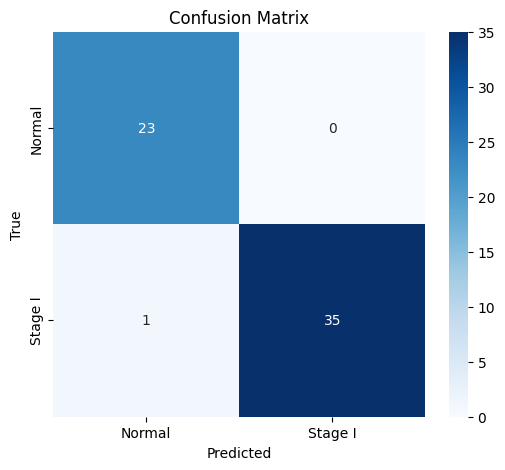

In [154]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

       Feature  Importance
16346    FXYD1    0.018715
20037   CORO2B    0.018255
8183     PROS1    0.018149
7595    SYNPO2    0.017096
17584    CEP68    0.016719
18428   PLSCR4    0.015527
19058   MAMDC2    0.011636
752      TSHZ2    0.010786
13168     IL33    0.010240
16944  TMEM220    0.010151


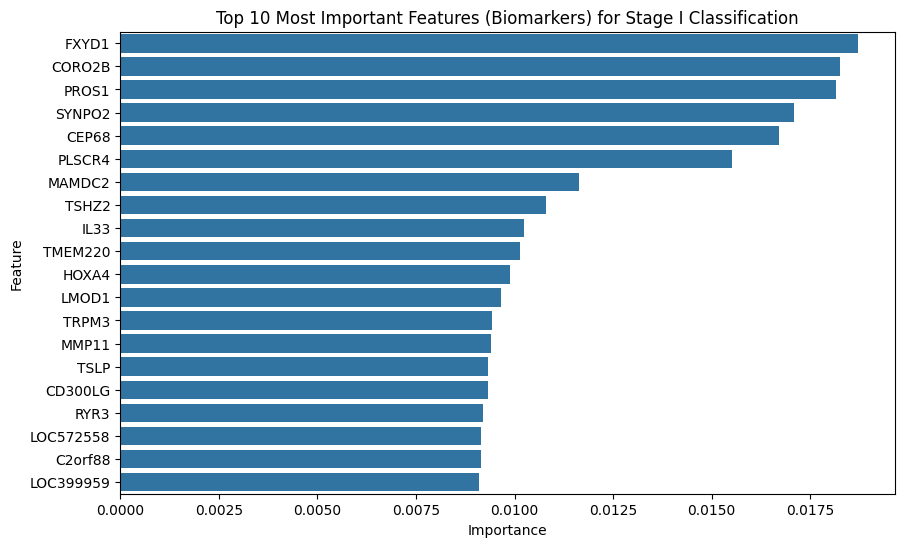

In [157]:



feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns,'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


print(importance_df.head(10))


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 10 Most Important Features (Biomarkers) for Stage I Classification")
plt.show()


### RF trained on significant genes

In [166]:
significant_genes = stage1_vs_normal['Feature'].tolist()

In [167]:
significant_genes

['MMP11',
 'COL10A1',
 'IBSP',
 'NEK2',
 'BMP8A',
 'KIAA0101',
 'HSD17B6',
 'PKMYT1',
 'UBE2T',
 'PPAPDC1A',
 'KIF4A',
 'GABRD',
 'UHRF1',
 'NUF2',
 'CDK1',
 'SPC25',
 'COL11A1',
 'ASF1B',
 'CDCA8',
 'UBE2C',
 'IQGAP3',
 'TPX2',
 'AURKA',
 'ESM1',
 'GPRIN1',
 'HJURP',
 'CILP2',
 'MMP13',
 'CLEC5A',
 'CDKN3',
 'CDC25C',
 'PLK1',
 'HAGHL',
 'TROAP',
 'KIFC1',
 'CCDC64',
 'KIF2C',
 'PROC',
 'WDR62',
 'NUSAP1',
 'COMP',
 'CCNE2',
 'MELK',
 'NDC80',
 'CST1',
 'LOC283867',
 'KIF18B',
 'RECQL4',
 'FOXM1',
 'CEP55',
 'C16orf59',
 'WISP1',
 'PTTG1',
 'NCAPG',
 'SKA3',
 'BUB1B',
 'PBK',
 'CCNB2',
 'CDCA5',
 'CDCA3',
 'HMMR',
 'PRR19',
 'OIP5',
 'KIF20A',
 'DLGAP5',
 'CDC20',
 'SKA1',
 'DTL',
 'RRM2',
 'AURKB',
 'RPLP0P2',
 'ANLN',
 'CENPM',
 'FAM54A',
 'TOP2A',
 'BUB1',
 'RAD51',
 'CNIH2',
 'ASPM',
 'CCL11',
 'CHRNA6',
 'CKAP2L',
 'GTSE1',
 'NEIL3',
 'ERCC6L',
 'CTXN1',
 'EPR1',
 'RAD54L',
 'EXO1',
 'CST4',
 'SPC24',
 'SAMD14',
 'TDO2',
 'GJB2',
 'KIF14',
 'INHBA',
 'NCAPH',
 'ADAMTS14',
 'EME1'

In [168]:
X_sig = X.loc[:, significant_genes]

In [169]:
X_sig

,MMP11,COL10A1,IBSP,NEK2,BMP8A,KIAA0101,HSD17B6,PKMYT1,UBE2T,PPAPDC1A,...,TSLP,TMEM220,CD300LG,MME,HOXA4,MAMDC2,SDPR,FIGF,SCN4B,ADAMTS5
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-A8-A08A-01,14.0201,12.1031,7.0242,8.4414,8.3074,8.1641,6.2252,8.1949,8.1641,8.0913,...,0.4455,6.1898,2.4173,7.9100,5.5399,3.8467,5.0843,1.2912,5.9660,7.5042
TCGA-E2-A15O-01,12.4355,9.7283,1.7959,9.1223,8.2097,8.9419,7.8280,9.8674,8.7439,5.5209,...,3.0734,4.3187,3.3893,7.1903,3.8222,5.3399,5.5966,2.1032,5.5079,5.9346
TCGA-BH-A1FG-01,11.8765,10.1462,3.8186,7.6348,6.1407,8.0774,5.3207,7.9885,6.6911,5.6898,...,2.4249,5.1972,3.9262,6.8858,3.8540,5.1829,6.6706,3.4373,5.7882,5.6693
TCGA-BH-A8FY-01,9.7252,5.7318,5.4682,7.8321,7.4281,9.1953,4.6672,8.5746,9.1254,1.0768,...,2.2878,5.0519,3.9470,6.4609,6.0413,5.9612,7.2935,2.1138,6.9878,5.4315
TCGA-E9-A54X-01,8.4778,4.4822,5.0346,8.4225,5.6483,9.0906,3.3129,7.6900,8.3029,2.7987,...,0.5816,2.8982,0.0000,2.7987,1.5783,4.1198,2.1621,1.5783,5.8481,4.1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A0D9-11,6.8139,3.9314,0.0000,2.7226,4.6690,3.7792,2.3429,1.0562,4.3468,0.5938,...,6.1133,8.2929,11.9927,12.9304,6.2324,9.8754,12.8532,9.5359,10.4131,11.3760
TCGA-BH-A1FN-11,7.9566,3.9465,0.0000,4.7829,5.5676,6.2253,4.8565,4.2135,6.1216,3.1817,...,7.0244,8.1418,8.7960,12.1260,8.2713,9.8705,11.0723,9.4962,9.8693,10.6260
TCGA-BH-A0HA-11,5.0101,1.1483,0.0000,4.9733,6.2406,5.3627,3.2503,4.7658,6.0507,2.3378,...,6.5833,8.5689,9.2267,12.3139,7.9466,10.4963,11.1237,7.7187,10.2483,12.4135


In [72]:
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(X_sig, y, test_size=0.2, random_state=42, stratify=y)

In [1]:
scaler = StandardScaler()
X_train_sig_scaled = scaler.fit_transform(X_train_sig)
X_test_sig_scaled = scaler.transform(X_test_sig)

NameError: name 'StandardScaler' is not defined

In [74]:
rf_sig = RandomForestClassifier(random_state=42)
rf_sig.fit(X_train_sig_scaled, y_train_sig)

y_pred_sig = rf_sig.predict(X_test_sig_scaled)
y_proba_sig = rf_sig.predict_proba(X_test_sig_scaled)[:, 1]

print("Accuracy (Significant Genes):", accuracy_score(y_test_sig, y_pred_sig))
print("ROC-AUC (Significant Genes):", roc_auc_score(y_test_sig, y_proba_sig))
print("\nClassification Report (Significant Genes):\n", classification_report(y_test_sig, y_pred_sig))

Accuracy (Significant Genes): 0.9830508474576272
ROC-AUC (Significant Genes): 1.0

Classification Report (Significant Genes):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.97      0.99        36

    accuracy                           0.98        59
   macro avg       0.98      0.99      0.98        59
weighted avg       0.98      0.98      0.98        59



In [68]:
0.9830508474576272

0.9830508474576272

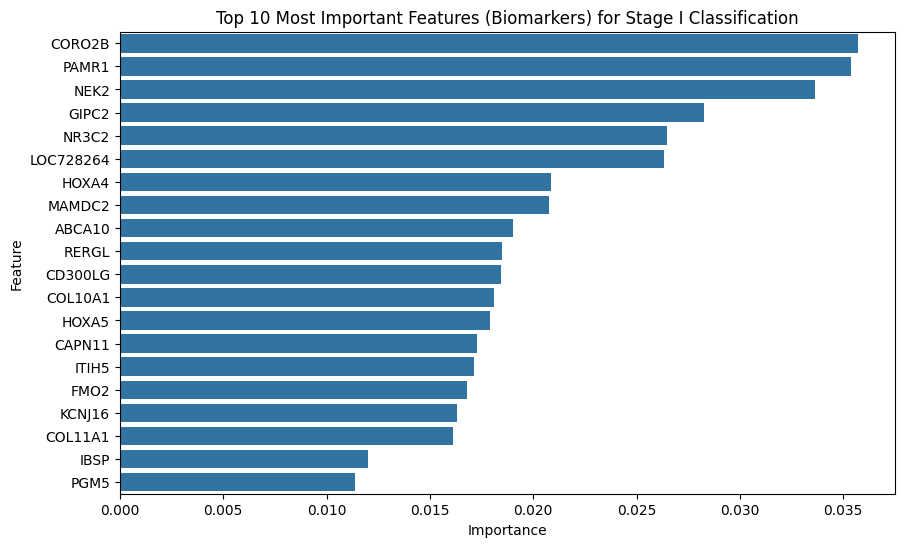

In [77]:
feature_importances_sig = rf_sig.feature_importances_
importance_df_sig = pd.DataFrame({'Feature': X_train_sig.columns,'Importance': feature_importances_sig})
importance_df_sig = importance_df_sig.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_sig.head(20))
plt.title("Top 10 Most Important Features (Biomarkers) for Stage I Classification")
plt.show()

### Adding SSGSEA features

In [76]:
pip install gseapy

Note: you may need to restart the kernel to use updated packages.


In [161]:
from gseapy import ssgsea

In [170]:
X_sig

,MMP11,COL10A1,IBSP,NEK2,BMP8A,KIAA0101,HSD17B6,PKMYT1,UBE2T,PPAPDC1A,...,TSLP,TMEM220,CD300LG,MME,HOXA4,MAMDC2,SDPR,FIGF,SCN4B,ADAMTS5
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-A8-A08A-01,14.0201,12.1031,7.0242,8.4414,8.3074,8.1641,6.2252,8.1949,8.1641,8.0913,...,0.4455,6.1898,2.4173,7.9100,5.5399,3.8467,5.0843,1.2912,5.9660,7.5042
TCGA-E2-A15O-01,12.4355,9.7283,1.7959,9.1223,8.2097,8.9419,7.8280,9.8674,8.7439,5.5209,...,3.0734,4.3187,3.3893,7.1903,3.8222,5.3399,5.5966,2.1032,5.5079,5.9346
TCGA-BH-A1FG-01,11.8765,10.1462,3.8186,7.6348,6.1407,8.0774,5.3207,7.9885,6.6911,5.6898,...,2.4249,5.1972,3.9262,6.8858,3.8540,5.1829,6.6706,3.4373,5.7882,5.6693
TCGA-BH-A8FY-01,9.7252,5.7318,5.4682,7.8321,7.4281,9.1953,4.6672,8.5746,9.1254,1.0768,...,2.2878,5.0519,3.9470,6.4609,6.0413,5.9612,7.2935,2.1138,6.9878,5.4315
TCGA-E9-A54X-01,8.4778,4.4822,5.0346,8.4225,5.6483,9.0906,3.3129,7.6900,8.3029,2.7987,...,0.5816,2.8982,0.0000,2.7987,1.5783,4.1198,2.1621,1.5783,5.8481,4.1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A0D9-11,6.8139,3.9314,0.0000,2.7226,4.6690,3.7792,2.3429,1.0562,4.3468,0.5938,...,6.1133,8.2929,11.9927,12.9304,6.2324,9.8754,12.8532,9.5359,10.4131,11.3760
TCGA-BH-A1FN-11,7.9566,3.9465,0.0000,4.7829,5.5676,6.2253,4.8565,4.2135,6.1216,3.1817,...,7.0244,8.1418,8.7960,12.1260,8.2713,9.8705,11.0723,9.4962,9.8693,10.6260
TCGA-BH-A0HA-11,5.0101,1.1483,0.0000,4.9733,6.2406,5.3627,3.2503,4.7658,6.0507,2.3378,...,6.5833,8.5689,9.2267,12.3139,7.9466,10.4963,11.1237,7.7187,10.2483,12.4135


In [162]:
gene_set_file="h.all.v2024.1.Hs.symbols.gmt"

In [172]:
ssgsea_results = ssgsea(data=X_sig.T,  # Transpose: genes as rows
                        gene_sets=gene_set_file,
                        outdir="ssgsea_results",  # Specify the output directory
                        min_size=15,  # Minimum gene set size
                        max_size=500,  # Maximum gene set size
                        scale=True)  # Normalize the enrichment scores

In [173]:
from gseapy.parser import read_gmt

gmt = read_gmt(gene_set_file)
print("Example gene set:", list(gmt.items())[:1])

Example gene set: [('HALLMARK_ADIPOGENESIS', ['ABCA1', 'ABCB8', 'ACAA2', 'ACADL', 'ACADM', 'ACADS', 'ACLY', 'ACO2', 'ACOX1', 'ADCY6', 'ADIG', 'ADIPOQ', 'ADIPOR2', 'AGPAT3', 'AIFM1', 'AK2', 'ALDH2', 'ALDOA', 'ANGPT1', 'ANGPTL4', 'APLP2', 'APOE', 'ARAF', 'ARL4A', 'ATL2', 'ATP1B3', 'ATP5PO', 'BAZ2A', 'BCKDHA', 'BCL2L13', 'BCL6', 'C3', 'CAT', 'CAVIN1', 'CAVIN2', 'CCNG2', 'CD151', 'CD302', 'CD36', 'CDKN2C', 'CHCHD10', 'CHUK', 'CIDEA', 'CMBL', 'CMPK1', 'COL15A1', 'COL4A1', 'COQ3', 'COQ5', 'COQ9', 'COX6A1', 'COX7B', 'COX8A', 'CPT2', 'CRAT', 'CS', 'CYC1', 'CYP4B1', 'DBT', 'DDT', 'DECR1', 'DGAT1', 'DHCR7', 'DHRS7', 'DHRS7B', 'DLAT', 'DLD', 'DNAJB9', 'DNAJC15', 'DRAM2', 'ECH1', 'ECHS1', 'ELMOD3', 'ELOVL6', 'ENPP2', 'EPHX2', 'ESRRA', 'ESYT1', 'ETFB', 'FABP4', 'FAH', 'FZD4', 'G3BP2', 'GADD45A', 'GBE1', 'GHITM', 'GPAM', 'GPAT4', 'GPD2', 'GPHN', 'GPX3', 'GPX4', 'GRPEL1', 'HADH', 'HIBCH', 'HSPB8', 'IDH1', 'IDH3A', 'IDH3G', 'IFNGR1', 'IMMT', 'ITGA7', 'ITIH5', 'ITSN1', 'JAGN1', 'LAMA4', 'LEP', 'LIFR', 

In [174]:
ssgsea_results

In [175]:
ssgsea_scores = pd.read_csv("ssgsea_results/gseapy.gene_set.ssgsea.report.csv", index_col=0)


In [183]:
ssgsea_scores.loc["TCGA-BH-A209-01"]

,Term,ES,NES
Name,,,
TCGA-BH-A209-01,HALLMARK_MITOTIC_SPINDLE,1509.608621,0.875953
TCGA-BH-A209-01,HALLMARK_E2F_TARGETS,1493.972190,0.866880
TCGA-BH-A209-01,HALLMARK_G2M_CHECKPOINT,1476.577524,0.856787
TCGA-BH-A209-01,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,1181.297700,0.685450
TCGA-BH-A209-01,HALLMARK_TNFA_SIGNALING_VIA_NFKB,1083.080758,0.628459
TCGA-BH-A209-01,HALLMARK_ADIPOGENESIS,992.222274,0.575739
TCGA-BH-A209-01,HALLMARK_INFLAMMATORY_RESPONSE,867.727585,0.503500
TCGA-BH-A209-01,HALLMARK_GLYCOLYSIS,772.572990,0.448287
TCGA-BH-A209-01,HALLMARK_COMPLEMENT,750.508299,0.435484


In [208]:
ssgsea_pivoted = ssgsea_scores.pivot_table(index='Name', columns='Term', values='NES')

In [209]:
ssgsea_pivoted

Term,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_APICAL_JUNCTION,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_COAGULATION,HALLMARK_COMPLEMENT,HALLMARK_E2F_TARGETS,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_G2M_CHECKPOINT,...,HALLMARK_HEME_METABOLISM,HALLMARK_HYPOXIA,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_MITOTIC_SPINDLE,HALLMARK_MYOGENESIS,HALLMARK_SPERMATOGENESIS,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_XENOBIOTIC_METABOLISM
Name,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AALK-01,0.437681,0.218993,0.396537,0.309071,0.274690,0.305853,0.816162,0.657132,0.374899,0.793825,...,-0.124047,0.274315,0.296962,0.169821,0.372066,0.833801,0.323717,0.172474,0.544008,0.336026
TCGA-A1-A0SB-01,0.478981,0.010489,0.374467,0.320016,0.096730,0.160535,0.738900,0.592807,0.397007,0.728317,...,0.015084,0.318711,0.184839,0.176803,0.333042,0.763135,0.248562,0.216650,0.427227,0.259205
TCGA-A1-A0SE-01,0.439019,0.089341,0.382757,0.389958,0.299892,0.266303,0.830268,0.632008,0.267175,0.811272,...,0.038030,0.245718,0.217496,0.092160,0.359714,0.839595,0.368166,0.150536,0.445968,0.279138
TCGA-A2-A04N-01,0.402413,0.176219,0.402211,0.349390,0.254020,0.364991,0.798452,0.659549,0.264830,0.791936,...,-0.046683,0.198316,0.277941,0.150217,0.322466,0.828052,0.333730,0.225693,0.499039,0.310136
TCGA-A2-A04Q-01,0.509686,0.400500,0.379543,0.361151,0.265768,0.366758,0.848180,0.729903,0.306875,0.839651,...,-0.052241,0.168019,0.503914,0.166966,0.427029,0.862482,0.321722,0.115026,0.700788,0.327138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-OL-A6VO-01,0.583050,0.348408,0.257559,0.347211,0.284303,0.354351,0.859541,0.636313,0.424806,0.849901,...,0.067613,0.387301,0.465863,0.106618,0.444902,0.874252,0.248274,0.226165,0.646609,0.311405
TCGA-OL-A6VR-01,0.458176,0.104495,0.334612,0.409055,0.297748,0.317261,0.778939,0.579583,0.405955,0.754608,...,0.008663,0.319128,0.159863,0.132839,0.326523,0.789065,0.358125,0.213198,0.366853,0.301477
TCGA-S3-AA14-01,0.555684,0.159441,0.338912,0.410884,0.212909,0.187341,0.813138,0.632809,0.435399,0.798331,...,0.105719,0.175322,0.175592,0.110679,0.387706,0.826108,0.323202,0.135458,0.462518,0.281646


In [210]:
merged_df = pd.merge(X_sig, ssgsea_pivoted,  how='left',left_on=None, right_on=None, left_index=True, right_index=True)

In [211]:
merged_df

,MMP11,COL10A1,IBSP,NEK2,BMP8A,KIAA0101,HSD17B6,PKMYT1,UBE2T,PPAPDC1A,...,HALLMARK_HEME_METABOLISM,HALLMARK_HYPOXIA,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_MITOTIC_SPINDLE,HALLMARK_MYOGENESIS,HALLMARK_SPERMATOGENESIS,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_XENOBIOTIC_METABOLISM
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-A8-A08A-01,14.0201,12.1031,7.0242,8.4414,8.3074,8.1641,6.2252,8.1949,8.1641,8.0913,...,0.115035,0.275236,0.279271,0.081742,0.349145,0.819927,0.363075,0.232362,0.419565,0.232418
TCGA-E2-A15O-01,12.4355,9.7283,1.7959,9.1223,8.2097,8.9419,7.8280,9.8674,8.7439,5.5209,...,0.006011,0.335922,0.347713,0.129103,0.384386,0.860883,0.296602,0.176226,0.532828,0.258065
TCGA-BH-A1FG-01,11.8765,10.1462,3.8186,7.6348,6.1407,8.0774,5.3207,7.9885,6.6911,5.6898,...,0.047139,0.180819,0.275442,0.121589,0.368440,0.836254,0.293391,0.218402,0.523036,0.277595
TCGA-BH-A8FY-01,9.7252,5.7318,5.4682,7.8321,7.4281,9.1953,4.6672,8.5746,9.1254,1.0768,...,0.061876,0.300388,0.162252,0.062881,0.325473,0.838065,0.315524,0.245104,0.362825,0.400069
TCGA-E9-A54X-01,8.4778,4.4822,5.0346,8.4225,5.6483,9.0906,3.3129,7.6900,8.3029,2.7987,...,0.016715,0.239590,0.111070,0.024284,0.195161,0.844080,0.188522,0.367822,0.219471,0.247704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A0D9-11,6.8139,3.9314,0.0000,2.7226,4.6690,3.7792,2.3429,1.0562,4.3468,0.5938,...,0.388498,0.379895,0.333292,0.105129,0.425572,0.461316,0.438685,0.046816,0.501439,0.412547
TCGA-BH-A1FN-11,7.9566,3.9465,0.0000,4.7829,5.5676,6.2253,4.8565,4.2135,6.1216,3.1817,...,0.018098,0.316617,0.295905,0.119005,0.503914,0.630999,0.324229,0.175608,0.581329,0.334619
TCGA-BH-A0HA-11,5.0101,1.1483,0.0000,4.9733,6.2406,5.3627,3.2503,4.7658,6.0507,2.3378,...,0.017061,0.347234,0.170676,0.106775,0.342270,0.618435,0.287315,0.126007,0.438942,0.307998


In [212]:
y

0       1
1       1
2       1
3       1
4       1
       ..
6190    0
6191    0
6192    0
6193    0
6194    0
Name: combined_stage, Length: 6195, dtype: int64

In [216]:
y = y.loc[merged_df.index].reset_index(drop=True)

In [217]:
y

0      1
1      1
2      1
3      1
4      1
      ..
290    0
291    0
292    0
293    0
294    0
Name: combined_stage, Length: 295, dtype: int64

In [219]:
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(merged_df, y, test_size=0.2, random_state=42, stratify=y)

In [220]:
X_train_sig

,MMP11,COL10A1,IBSP,NEK2,BMP8A,KIAA0101,HSD17B6,PKMYT1,UBE2T,PPAPDC1A,...,HALLMARK_HEME_METABOLISM,HALLMARK_HYPOXIA,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_MITOTIC_SPINDLE,HALLMARK_MYOGENESIS,HALLMARK_SPERMATOGENESIS,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_XENOBIOTIC_METABOLISM
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-E2-A1IJ-01,13.3329,13.4690,5.0770,7.4569,7.7168,7.3756,8.0497,7.6836,7.3245,9.0487,...,-0.016283,0.285886,0.345515,0.167461,0.417232,0.781693,0.409827,0.162396,0.637737,0.291468
TCGA-BH-A208-11,6.4885,3.6436,0.3999,2.5338,5.8936,2.9462,3.0048,2.1691,4.7307,0.7126,...,0.020556,0.441495,0.223816,0.093560,0.423373,0.424685,0.334478,0.104636,0.499000,0.382257
TCGA-GI-A2C8-11,6.0134,2.2077,0.0000,2.2077,5.6913,3.4362,0.6013,2.0952,7.7624,0.0000,...,0.247325,0.313987,0.312631,0.205322,0.322653,0.486778,0.825989,0.136303,0.450036,0.289279
TCGA-BH-A18M-11,10.3922,8.8763,1.2155,5.4512,6.0779,5.7281,4.0760,5.2995,5.9704,4.6322,...,0.085067,0.351666,0.355770,0.136448,0.455029,0.586742,0.432068,0.075934,0.543349,0.338550
TCGA-GM-A2DO-01,12.1329,8.2901,6.1869,8.6246,7.8352,9.3737,4.4376,9.3109,8.1769,4.3002,...,-0.044937,0.102979,0.353342,0.194173,0.312802,0.864375,0.361613,0.192830,0.594057,0.238008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A0HB-01,12.7895,10.1623,2.6463,9.8995,8.1332,9.6824,6.3289,9.7205,10.3071,6.5438,...,-0.031240,0.242965,0.443953,0.235799,0.435152,0.844187,0.352992,0.199621,0.611806,0.428664
TCGA-E2-A1II-01,7.9212,7.0989,4.3428,10.0254,5.3443,7.3592,5.9298,7.6200,9.1424,1.0305,...,0.100168,0.040407,0.437444,0.157576,0.446230,0.871997,0.193395,0.263050,0.686172,0.226248
TCGA-A7-A26F-01,14.0386,11.0786,7.4284,8.5968,8.4793,7.9140,6.6159,7.3409,8.3857,7.2836,...,-0.115058,0.252436,0.551654,0.183672,0.477607,0.845122,0.171126,0.173510,0.733517,0.286576


In [221]:
scaler = StandardScaler()
X_train_sig_scaled = scaler.fit_transform(X_train_sig)
X_test_sig_scaled = scaler.transform(X_test_sig)

In [222]:
rf_sig = RandomForestClassifier(random_state=42)
rf_sig.fit(X_train_sig_scaled, y_train_sig)

y_pred_sig = rf_sig.predict(X_test_sig_scaled)
y_proba_sig = rf_sig.predict_proba(X_test_sig_scaled)[:, 1]

print("Accuracy (Significant Genes and ssgsea features):", accuracy_score(y_test_sig, y_pred_sig))
print("ROC-AUC (Significant Genes and ssgsea features):", roc_auc_score(y_test_sig, y_proba_sig))
print("\nClassification Report (Significant Genes):\n", classification_report(y_test_sig, y_pred_sig))

Accuracy (Significant Genes and ssgsea features): 0.9830508474576272
ROC-AUC (Significant Genes and ssgsea features): 0.9975845410628019

Classification Report (Significant Genes):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.97      0.99        36

    accuracy                           0.98        59
   macro avg       0.98      0.99      0.98        59
weighted avg       0.98      0.98      0.98        59



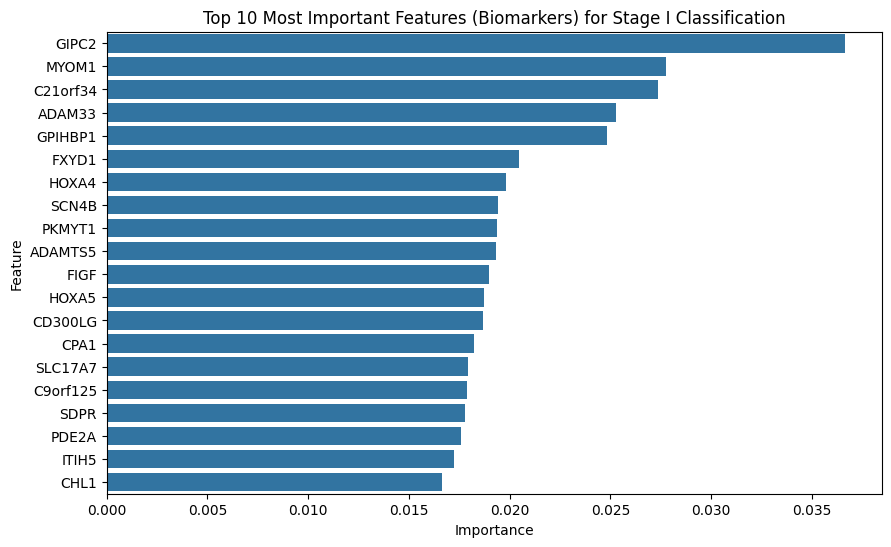

In [223]:
feature_importances_sig = rf_sig.feature_importances_
importance_df_sig = pd.DataFrame({'Feature': X_train_sig.columns,'Importance': feature_importances_sig})
importance_df_sig = importance_df_sig.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_sig.head(20))
plt.title("Top 10 Most Important Features (Biomarkers) for Stage I Classification")
plt.show()

In [225]:
corr_matrix = X_train_sig.corr()

In [226]:
corr_matrix

,MMP11,COL10A1,IBSP,NEK2,BMP8A,KIAA0101,HSD17B6,PKMYT1,UBE2T,PPAPDC1A,...,HALLMARK_HEME_METABOLISM,HALLMARK_HYPOXIA,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_MITOTIC_SPINDLE,HALLMARK_MYOGENESIS,HALLMARK_SPERMATOGENESIS,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_XENOBIOTIC_METABOLISM
MMP11,1.000000,0.949279,0.784318,0.798203,0.880859,0.797230,0.874510,0.804231,0.757969,0.923162,...,-0.390838,-0.662264,0.296361,0.296992,-0.197568,0.844793,-0.318239,0.622933,0.275979,-0.619297
COL10A1,0.949279,1.000000,0.770347,0.777827,0.852568,0.751259,0.900551,0.734236,0.712310,0.933383,...,-0.418727,-0.641412,0.288571,0.275157,-0.168413,0.821717,-0.341225,0.613471,0.283909,-0.625457
IBSP,0.784318,0.770347,1.000000,0.727407,0.762311,0.725940,0.718862,0.684940,0.687627,0.718018,...,-0.278954,-0.600685,0.238564,0.187137,-0.245806,0.778193,-0.359565,0.639479,0.212150,-0.625629
NEK2,0.798203,0.777827,0.727407,1.000000,0.769972,0.936813,0.740643,0.920613,0.943569,0.722507,...,-0.457461,-0.646701,0.294357,0.296903,-0.200658,0.954771,-0.499712,0.779267,0.293555,-0.663598
BMP8A,0.880859,0.852568,0.762311,0.769972,1.000000,0.746493,0.812981,0.744514,0.726101,0.832366,...,-0.456132,-0.553480,0.208394,0.300587,-0.142831,0.799556,-0.315358,0.615218,0.200367,-0.565624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HALLMARK_MITOTIC_SPINDLE,0.844793,0.821717,0.778193,0.954771,0.799556,0.931011,0.776861,0.919527,0.897692,0.760389,...,-0.428022,-0.700806,0.267438,0.264363,-0.261824,1.000000,-0.486674,0.817753,0.282566,-0.717589
HALLMARK_MYOGENESIS,-0.318239,-0.341225,-0.359565,-0.499712,-0.315358,-0.446232,-0.362346,-0.409270,-0.450429,-0.276576,...,0.451573,0.360569,-0.181334,-0.077503,0.072187,-0.486674,1.000000,-0.452265,-0.262547,0.369793
HALLMARK_SPERMATOGENESIS,0.622933,0.613471,0.639479,0.779267,0.615218,0.776902,0.599735,0.715763,0.773394,0.546968,...,-0.296030,-0.611375,0.178724,0.179574,-0.344860,0.817753,-0.452265,1.000000,0.141806,-0.648414
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.275979,0.283909,0.212150,0.293555,0.200367,0.302678,0.243323,0.248721,0.285421,0.323053,...,-0.169351,-0.144870,0.837900,0.391139,0.561881,0.282566,-0.262547,0.141806,1.000000,-0.041777


### Using raw counts and various ML models

In [2]:
raw_df= pd.read_csv("raw_counts.csv")

In [3]:
raw_df=raw_df.set_index("Unnamed: 0")

In [4]:
raw_df=raw_df.T

In [5]:
raw_df

Unnamed: 0,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-5L-AAT0-01A,2878,5,918,679,242,366,1729,1100,796,1451,...,0,0,39,0,0,0,189,0,5,10
TCGA-A2-A04U-01A,4743,20,3667,491,241,139,614,1348,759,2120,...,0,0,12,0,0,0,878,0,13,9
TCGA-AN-A04A-01A,1417,9,1982,1227,284,215,4016,2753,870,1557,...,0,0,6,0,0,0,279,0,0,32
TCGA-A7-A13D-01A,3018,0,2817,591,1083,231,1495,2554,918,2623,...,0,0,26,0,0,0,436,0,8,4
TCGA-BH-A201-01A,3555,30,2537,1865,890,711,4352,2175,2472,3796,...,0,0,38,0,0,0,590,0,11,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A2-A1FV-01A,2187,74,1914,4813,1323,201,2911,2350,2897,5174,...,0,0,79,0,3,2,1411,0,8,28
TCGA-C8-A275-01A,2854,10,2996,4037,1431,1856,4980,2556,2293,3668,...,0,1,18,0,0,0,358,0,4,10
TCGA-A2-A0CS-01A,2056,9,1873,1128,447,311,2048,2065,1630,1686,...,0,0,3,0,0,0,301,0,5,11
TCGA-AR-A0TU-01A,8943,10,2621,1804,2349,1050,736,1765,3772,3994,...,0,0,29,0,0,0,266,0,2,15


In [6]:
meta=pd.read_csv("clinical (1).csv")

In [7]:
meta["sample_type"].value_counts()

sample_type
Primary Tumor          1111
Solid Tissue Normal     113
Metastatic                7
Name: count, dtype: int64

In [8]:
meta=meta.set_index("sample")

In [9]:
meta=meta.drop(columns=["barcode", "patient", "sample_submitter_id", "sample_id", "submitter_id", "Unnamed: 0"])

In [10]:
meta

,shortLetterCode,definition,sample_type_id,tumor_descriptor,sample_type,oct_embedded,specimen_type,state,is_ffpe,tissue_type,...,paper_tobacco_smoking_history,paper_CNV.Clusters,paper_Mutation.Clusters,paper_DNA.Methylation.Clusters,paper_mRNA.Clusters,paper_miRNA.Clusters,paper_lncRNA.Clusters,paper_Protein.Clusters,paper_PARADIGM.Clusters,paper_Pan.Gyn.Clusters
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-5L-AAT0-01A,TP,Primary solid Tumor,1,Primary,Primary Tumor,False,Solid Tissue,released,False,Tumor,...,NaN,C1,C9,C1,C2,C2,NaN,NaN,C6,NaN
TCGA-A2-A04U-01A,TP,Primary solid Tumor,1,Primary,Primary Tumor,True,Solid Tissue,released,False,Tumor,...,NaN,C6,C1,C4,C4,C7,C2,C5,C2,C5
TCGA-AN-A04A-01A,TP,Primary solid Tumor,1,Primary,Primary Tumor,True,Solid Tissue,released,False,Tumor,...,NaN,C6,C1,C1,C1,C3,C2,C1,C5,C5
TCGA-A7-A13D-01A,TP,Primary solid Tumor,1,Primary,Primary Tumor,False,Solid Tissue,released,False,Tumor,...,NaN,C4,C1,C4,C4,C7,C2,C5,C2,C5
TCGA-BH-A201-01A,TP,Primary solid Tumor,1,Primary,Primary Tumor,True,Solid Tissue,released,False,Tumor,...,NaN,C5,C4,C1,C2,C3,C2,C1,C6,C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A2-A1FV-01A,TP,Primary solid Tumor,1,Primary,Primary Tumor,True,Solid Tissue,released,False,Tumor,...,NaN,C5,C4,C2,C1,C2,C2,C2,C5,C5
TCGA-C8-A275-01A,TP,Primary solid Tumor,1,Primary,Primary Tumor,True,Solid Tissue,released,False,Tumor,...,NaN,C6,C9,C2,C2,C2,C1,C1,C4,C3
TCGA-A2-A0CS-01A,TP,Primary solid Tumor,1,Primary,Primary Tumor,True,Solid Tissue,released,False,Tumor,...,NaN,C1,C3,C1,C1,C3,C2,C1,C5,C1


In [11]:
import mygene

In [12]:
X=raw_df.iloc[:, 0:60660]

In [13]:
X.columns =X.columns.str.split('.').str[0]

# Initialize mygene client
mg = mygene.MyGeneInfo()

# Query Ensembl IDs to get gene symbols
query_results = mg.querymany(X.columns.tolist(), scopes='ensembl.gene', fields='symbol', species='human')

# Create mapping from Ensembl ID to Gene Symbol
mapping = {item['query']: item.get('symbol', None) for item in query_results}



72 input query terms found dup hits:	[('ENSG00000002586', 2), ('ENSG00000124333', 2), ('ENSG00000124334', 2), ('ENSG00000167393', 2), ('E
1242 input query terms found no hit:	['ENSG00000112096', 'ENSG00000130723', 'ENSG00000131484', 'ENSG00000132832', 'ENSG00000137808', 'ENS


In [14]:
X.rename(columns=mapping, inplace=True)

In [15]:
X= X.loc[:, X.columns.notna()]

In [16]:
valid_features = (X.mean(axis=0) > 0)
X = X.loc[:, valid_features]
X = X.loc[:, (X != X.iloc[0]).any()]

In [17]:
X= np.log2(X+1)

In [18]:
X

Unnamed: 0,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,ELOA3BP,NPBWR1,ELOA3DP,PDCD6-AHRR,ELOA3P,LNCDAT,RNF228,LOC101927145,PSEN2,PANO1
TCGA-5L-AAT0-01A,11.491352,2.584963,9.843921,9.409391,7.924813,8.519636,10.756556,10.104599,9.638436,10.503826,...,0.0,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.0,2.584963,3.459432
TCGA-A2-A04U-01A,12.211888,4.392317,11.840778,8.942515,7.918863,7.129283,9.264443,10.397675,9.569856,11.050529,...,0.0,1.000000,0.0,0.0,0.0,4.000000,7.108524,0.0,3.807355,3.321928
TCGA-AN-A04A-01A,10.469642,3.321928,10.953469,10.262095,8.154818,7.754888,11.971903,11.427313,9.766529,10.605480,...,0.0,2.584963,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,5.044394
TCGA-A7-A13D-01A,11.559855,0.000000,11.460456,9.209453,10.082149,7.857981,10.546894,11.319108,9.843921,11.357552,...,0.0,4.523562,0.0,0.0,0.0,0.000000,4.087463,0.0,3.169925,2.321928
TCGA-BH-A201-01A,11.796040,4.954196,11.309476,10.865733,9.799282,9.475733,12.087794,11.087463,11.272047,11.890644,...,0.0,1.584963,0.0,0.0,0.0,0.000000,3.169925,0.0,3.584963,4.857981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A2-A1FV-01A,11.095397,6.228819,10.903129,12.233020,10.370687,7.658211,11.507795,11.199059,11.500842,12.337343,...,0.0,2.321928,0.0,0.0,0.0,1.584963,2.321928,0.0,3.169925,4.857981
TCGA-C8-A275-01A,11.479275,3.459432,11.549303,11.979425,10.483816,10.858758,12.282220,11.320236,11.163650,11.841171,...,0.0,4.807355,0.0,0.0,0.0,1.000000,2.807355,0.0,2.321928,3.459432
TCGA-A2-A0CS-01A,11.006326,3.321928,10.871905,10.140830,8.807355,8.285402,11.000704,11.012625,10.671541,10.720244,...,0.0,0.000000,0.0,0.0,0.0,0.000000,4.523562,0.0,2.584963,3.584963
TCGA-AR-A0TU-01A,13.126704,3.459432,11.356452,10.817783,11.198445,10.037547,9.525521,10.786270,11.881496,11.963980,...,1.0,0.000000,0.0,0.0,0.0,0.000000,5.129283,0.0,1.584963,4.000000


In [19]:
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

In [20]:
s=X[numeric_cols].isna().any()

In [21]:
merge_df = pd.merge(X, meta, left_index=True, right_index=True)

In [22]:
categorical_cols = merge_df.select_dtypes(include=['object']).columns

In [23]:
merge_df[categorical_cols] = merge_df[categorical_cols].fillna("Unknown")

In [24]:
merge_df

,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,paper_tobacco_smoking_history,paper_CNV.Clusters,paper_Mutation.Clusters,paper_DNA.Methylation.Clusters,paper_mRNA.Clusters,paper_miRNA.Clusters,paper_lncRNA.Clusters,paper_Protein.Clusters,paper_PARADIGM.Clusters,paper_Pan.Gyn.Clusters
TCGA-5L-AAT0-01A,11.491352,2.584963,9.843921,9.409391,7.924813,8.519636,10.756556,10.104599,9.638436,10.503826,...,NaN,C1,C9,C1,C2,C2,Unknown,Unknown,C6,Unknown
TCGA-A2-A04U-01A,12.211888,4.392317,11.840778,8.942515,7.918863,7.129283,9.264443,10.397675,9.569856,11.050529,...,NaN,C6,C1,C4,C4,C7,C2,C5,C2,C5
TCGA-AN-A04A-01A,10.469642,3.321928,10.953469,10.262095,8.154818,7.754888,11.971903,11.427313,9.766529,10.605480,...,NaN,C6,C1,C1,C1,C3,C2,C1,C5,C5
TCGA-A7-A13D-01A,11.559855,0.000000,11.460456,9.209453,10.082149,7.857981,10.546894,11.319108,9.843921,11.357552,...,NaN,C4,C1,C4,C4,C7,C2,C5,C2,C5
TCGA-A7-A13D-01A,11.559855,0.000000,11.460456,9.209453,10.082149,7.857981,10.546894,11.319108,9.843921,11.357552,...,NaN,C4,C1,C4,C4,C7,C2,C5,C2,C5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A2-A1FV-01A,11.095397,6.228819,10.903129,12.233020,10.370687,7.658211,11.507795,11.199059,11.500842,12.337343,...,NaN,C5,C4,C2,C1,C2,C2,C2,C5,C5
TCGA-C8-A275-01A,11.479275,3.459432,11.549303,11.979425,10.483816,10.858758,12.282220,11.320236,11.163650,11.841171,...,NaN,C6,C9,C2,C2,C2,C1,C1,C4,C3
TCGA-A2-A0CS-01A,11.006326,3.321928,10.871905,10.140830,8.807355,8.285402,11.000704,11.012625,10.671541,10.720244,...,NaN,C1,C3,C1,C1,C3,C2,C1,C5,C1
TCGA-AR-A0TU-01A,13.126704,3.459432,11.356452,10.817783,11.198445,10.037547,9.525521,10.786270,11.881496,11.963980,...,NaN,Unknown,C1,C4,C4,Unknown,C2,C5,Unknown,C3


In [25]:
merge_df.loc[merge_df['sample_type'] == 'Solid Tissue Normal', 'ajcc_pathologic_stage'] = 'Normal'

In [26]:
stage_mapping = {
    'Stage I': 'Stage I',
    'Stage IA': 'Stage I',
    'Stage IB': 'Stage I',
    'Stage II': 'Stage II',
    'Stage IIA': 'Stage II',
    'Stage IIB': 'Stage II',
    'Stage III': 'Stage III',
    'Stage IIIA': 'Stage III',
    'Stage IIIB': 'Stage III',
    'Stage IIIC': 'Stage III',
    'Stage IV': 'Stage IV',
    'Stage X': 'Stage IV',
    'Normal': 'Normal',
    'Unknown':'Unknown',
    
}

# Apply mapping
merge_df['combined_stage'] = merge_df['ajcc_pathologic_stage'].map(stage_mapping)

In [27]:
merge_df

,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,paper_CNV.Clusters,paper_Mutation.Clusters,paper_DNA.Methylation.Clusters,paper_mRNA.Clusters,paper_miRNA.Clusters,paper_lncRNA.Clusters,paper_Protein.Clusters,paper_PARADIGM.Clusters,paper_Pan.Gyn.Clusters,combined_stage
TCGA-5L-AAT0-01A,11.491352,2.584963,9.843921,9.409391,7.924813,8.519636,10.756556,10.104599,9.638436,10.503826,...,C1,C9,C1,C2,C2,Unknown,Unknown,C6,Unknown,Stage II
TCGA-A2-A04U-01A,12.211888,4.392317,11.840778,8.942515,7.918863,7.129283,9.264443,10.397675,9.569856,11.050529,...,C6,C1,C4,C4,C7,C2,C5,C2,C5,Stage II
TCGA-AN-A04A-01A,10.469642,3.321928,10.953469,10.262095,8.154818,7.754888,11.971903,11.427313,9.766529,10.605480,...,C6,C1,C1,C1,C3,C2,C1,C5,C5,Stage III
TCGA-A7-A13D-01A,11.559855,0.000000,11.460456,9.209453,10.082149,7.857981,10.546894,11.319108,9.843921,11.357552,...,C4,C1,C4,C4,C7,C2,C5,C2,C5,Stage II
TCGA-A7-A13D-01A,11.559855,0.000000,11.460456,9.209453,10.082149,7.857981,10.546894,11.319108,9.843921,11.357552,...,C4,C1,C4,C4,C7,C2,C5,C2,C5,Stage II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A2-A1FV-01A,11.095397,6.228819,10.903129,12.233020,10.370687,7.658211,11.507795,11.199059,11.500842,12.337343,...,C5,C4,C2,C1,C2,C2,C2,C5,C5,Stage II
TCGA-C8-A275-01A,11.479275,3.459432,11.549303,11.979425,10.483816,10.858758,12.282220,11.320236,11.163650,11.841171,...,C6,C9,C2,C2,C2,C1,C1,C4,C3,Stage II
TCGA-A2-A0CS-01A,11.006326,3.321928,10.871905,10.140830,8.807355,8.285402,11.000704,11.012625,10.671541,10.720244,...,C1,C3,C1,C1,C3,C2,C1,C5,C1,Stage IV
TCGA-AR-A0TU-01A,13.126704,3.459432,11.356452,10.817783,11.198445,10.037547,9.525521,10.786270,11.881496,11.963980,...,Unknown,C1,C4,C4,Unknown,C2,C5,Unknown,C3,Stage II


## Normal vs Stage 1

In [28]:
y=merge_df["combined_stage"]

### Only

#### RF

In [29]:
merge_df

,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,paper_CNV.Clusters,paper_Mutation.Clusters,paper_DNA.Methylation.Clusters,paper_mRNA.Clusters,paper_miRNA.Clusters,paper_lncRNA.Clusters,paper_Protein.Clusters,paper_PARADIGM.Clusters,paper_Pan.Gyn.Clusters,combined_stage
TCGA-5L-AAT0-01A,11.491352,2.584963,9.843921,9.409391,7.924813,8.519636,10.756556,10.104599,9.638436,10.503826,...,C1,C9,C1,C2,C2,Unknown,Unknown,C6,Unknown,Stage II
TCGA-A2-A04U-01A,12.211888,4.392317,11.840778,8.942515,7.918863,7.129283,9.264443,10.397675,9.569856,11.050529,...,C6,C1,C4,C4,C7,C2,C5,C2,C5,Stage II
TCGA-AN-A04A-01A,10.469642,3.321928,10.953469,10.262095,8.154818,7.754888,11.971903,11.427313,9.766529,10.605480,...,C6,C1,C1,C1,C3,C2,C1,C5,C5,Stage III
TCGA-A7-A13D-01A,11.559855,0.000000,11.460456,9.209453,10.082149,7.857981,10.546894,11.319108,9.843921,11.357552,...,C4,C1,C4,C4,C7,C2,C5,C2,C5,Stage II
TCGA-A7-A13D-01A,11.559855,0.000000,11.460456,9.209453,10.082149,7.857981,10.546894,11.319108,9.843921,11.357552,...,C4,C1,C4,C4,C7,C2,C5,C2,C5,Stage II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A2-A1FV-01A,11.095397,6.228819,10.903129,12.233020,10.370687,7.658211,11.507795,11.199059,11.500842,12.337343,...,C5,C4,C2,C1,C2,C2,C2,C5,C5,Stage II
TCGA-C8-A275-01A,11.479275,3.459432,11.549303,11.979425,10.483816,10.858758,12.282220,11.320236,11.163650,11.841171,...,C6,C9,C2,C2,C2,C1,C1,C4,C3,Stage II
TCGA-A2-A0CS-01A,11.006326,3.321928,10.871905,10.140830,8.807355,8.285402,11.000704,11.012625,10.671541,10.720244,...,C1,C3,C1,C1,C3,C2,C1,C5,C1,Stage IV
TCGA-AR-A0TU-01A,13.126704,3.459432,11.356452,10.817783,11.198445,10.037547,9.525521,10.786270,11.881496,11.963980,...,Unknown,C1,C4,C4,Unknown,C2,C5,Unknown,C3,Stage II


In [30]:
rf_1_df= merge_df[merge_df["combined_stage"].isin(["Stage I", "Normal"])]

In [32]:
rf_1_df['combined_stage'] = rf_1_df['combined_stage'].map({'Normal': 0, 'Stage I': 1})

C:\Users\Neermita Bhattachary\AppData\Local\Temp\ipykernel_22704\210497803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_1_df['combined_stage'] = rf_1_df['combined_stage'].map({'Normal': 0, 'Stage I': 1})


In [34]:
X_rf_1= rf_1_df.iloc[:, 0:43430]

In [35]:
X_rf_1

,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,ELOA3BP,NPBWR1,ELOA3DP,PDCD6-AHRR,ELOA3P,LNCDAT,RNF228,LOC101927145,PSEN2,PANO1
TCGA-BH-A201-01A,11.796040,4.954196,11.309476,10.865733,9.799282,9.475733,12.087794,11.087463,11.272047,11.890644,...,0.0,1.584963,0.000000,0.0,0.0,0.000000,3.169925,0.0,3.584963,4.857981
TCGA-BH-A0H6-01A,12.434368,4.906891,10.562242,9.861087,8.233620,7.982994,10.614710,11.227014,11.533816,11.275543,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.584963,0.0,3.000000,4.087463
TCGA-A2-A04R-01A,10.605480,3.169925,10.834471,10.745674,9.985842,7.276124,10.293472,10.632995,10.650154,12.313166,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.584963,0.0,2.321928,3.584963
TCGA-E2-A1IH-01A,11.611486,5.554589,11.644307,10.985842,9.623881,10.614710,13.244661,11.880349,11.932953,11.982637,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,5.129283,0.0,4.000000,4.754888
TCGA-BH-A0EB-01A,9.917372,3.000000,11.100662,10.640245,8.962896,9.821774,11.861087,11.651949,11.417325,11.589651,...,0.0,2.584963,1.584963,0.0,0.0,0.000000,2.807355,0.0,1.584963,5.044394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A0HW-01A,10.970106,1.000000,11.179287,10.335390,8.768184,7.238405,9.287712,10.837628,11.339293,11.874597,...,0.0,1.584963,0.000000,0.0,0.0,1.000000,2.321928,0.0,1.000000,4.321928
TCGA-BH-A1EO-11A,12.654636,11.771902,11.904258,9.970106,8.535275,12.142426,15.005274,12.542790,12.221889,11.236612,...,0.0,3.321928,0.000000,0.0,0.0,6.247928,3.459432,0.0,3.700440,2.321928
TCGA-AC-A23H-11A,12.838613,7.857981,10.819381,10.436712,8.400879,8.879583,13.719817,11.580259,11.202736,11.300353,...,0.0,2.000000,0.000000,0.0,0.0,5.000000,5.169925,0.0,2.321928,2.807355
TCGA-GM-A2DH-01A,11.715962,3.000000,11.753635,11.187352,11.042343,10.274960,11.728771,12.608948,11.897845,12.639793,...,0.0,4.906891,1.000000,0.0,0.0,2.807355,4.584963,0.0,2.807355,5.285402


In [36]:
y_rf_1= rf_1_df["combined_stage"]

In [37]:
y_rf_1

TCGA-BH-A201-01A    1
TCGA-BH-A0H6-01A    1
TCGA-A2-A04R-01A    1
TCGA-E2-A1IH-01A    1
TCGA-BH-A0EB-01A    1
                   ..
TCGA-BH-A0HW-01A    1
TCGA-BH-A1EO-11A    0
TCGA-AC-A23H-11A    0
TCGA-GM-A2DH-01A    1
TCGA-AC-A8OR-01A    1
Name: combined_stage, Length: 297, dtype: int64

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [39]:
X_train_rf_1, X_test_rf_1, y_train_rf_1, y_test_rf_1 = train_test_split(X_rf_1, y_rf_1, test_size=0.2, random_state=42, stratify=y_rf_1)

In [40]:
scaler = StandardScaler()
X_train_scaled_rf_1 = scaler.fit_transform(X_train_rf_1)
X_test_scaled_rf_1 = scaler.transform(X_test_rf_1)

In [41]:
rf_1 = RandomForestClassifier(random_state=42)
rf_1.fit(X_train_scaled_rf_1, y_train_rf_1)
y_pred_rf_1 = rf_1.predict(X_test_scaled_rf_1)
y_proba_rf_1 = rf_1.predict_proba(X_test_scaled_rf_1)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_1, y_pred_rf_1))
print("ROC-AUC:", roc_auc_score(y_test_rf_1, y_proba_rf_1))
print("\nClassification Report:\n", classification_report(y_test_rf_1, y_pred_rf_1))

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



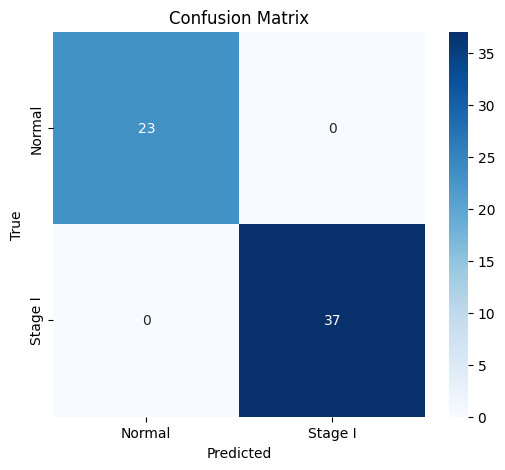

In [42]:
cm = confusion_matrix(y_test_rf_1, y_pred_rf_1)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

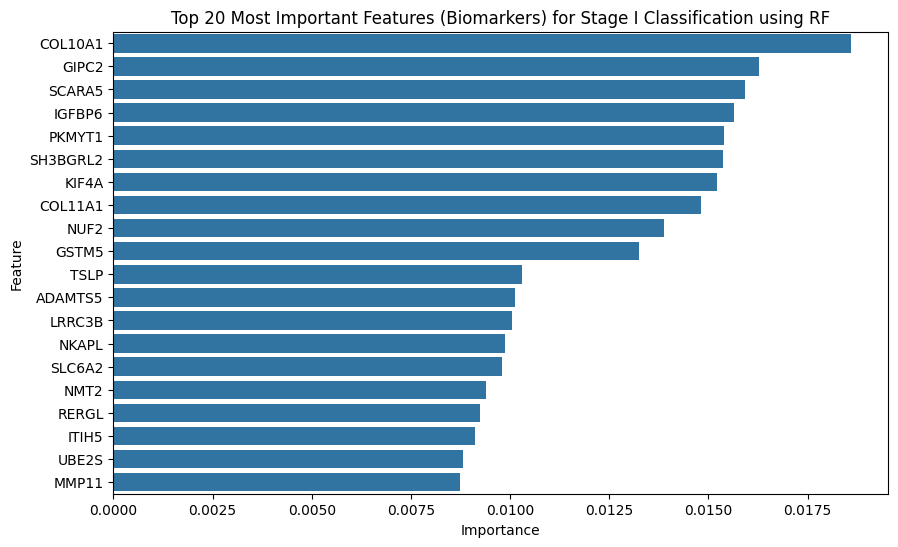

In [53]:
feature_importances = rf_1.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_1.columns,'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)



plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage I Classification using RF")
plt.show()

In [55]:
importance_df.to_csv("rf_only_features.csv")

#### Gradient Boosting

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled_rf_1, y_train_rf_1)
y_pred_gb = gb_model.predict(X_test_scaled_rf_1)
y_proba_gb = gb_model.predict_proba(X_test_scaled_rf_1)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_1, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test_rf_1, y_proba_gb))
print("\nClassification Report:\n", classification_report(y_test_rf_1, y_pred_gb))


Accuracy: 0.9833333333333333
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.97      0.99        37

    accuracy                           0.98        60
   macro avg       0.98      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



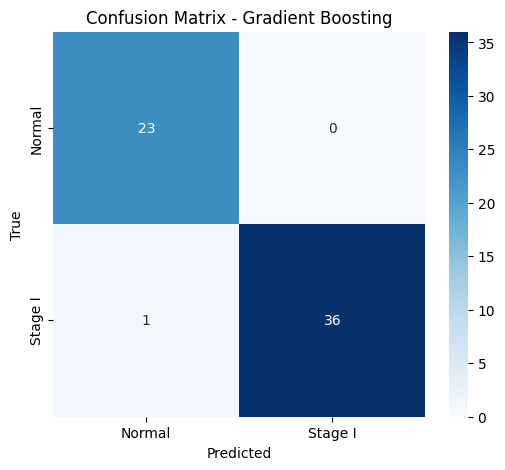

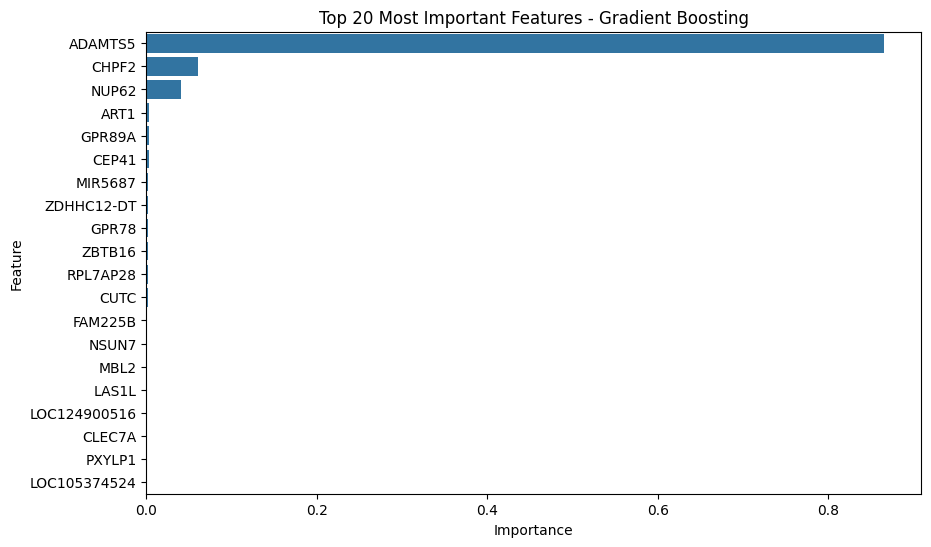

In [45]:
# Confusion Matrix
cm_gb = confusion_matrix(y_test_rf_1, y_pred_gb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances_gb = gb_model.feature_importances_
importance_df_gb = pd.DataFrame({'Feature': X_train_rf_1.columns, 'Importance': feature_importances_gb})
importance_df_gb = importance_df_gb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_gb.head(20))
plt.title("Top 20 Most Important Features - Gradient Boosting")
plt.show()


In [56]:
importance_df_gb.to_csv("gb_only_features.csv")

#### Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_scaled_rf_1, y_train_rf_1)
y_pred_logreg = logreg_model.predict(X_test_scaled_rf_1)
y_proba_logreg = logreg_model.predict_proba(X_test_scaled_rf_1)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_1, y_pred_logreg))
print("ROC-AUC:", roc_auc_score(y_test_rf_1, y_proba_logreg))
print("\nClassification Report:\n", classification_report(y_test_rf_1, y_pred_logreg))


Accuracy: 0.9666666666666667
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       1.00      0.95      0.97        37

    accuracy                           0.97        60
   macro avg       0.96      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



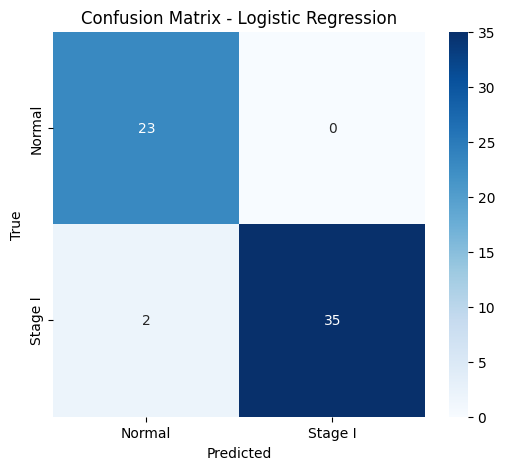

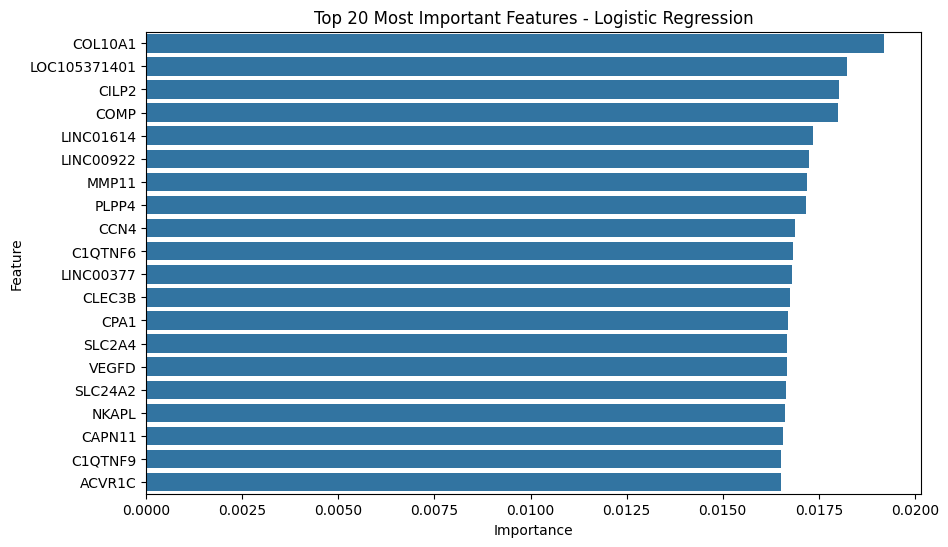

In [47]:
# Confusion Matrix
cm_logreg = confusion_matrix(y_test_rf_1, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance (For Logistic Regression, it can be derived from the coefficients)
feature_importances_logreg = abs(logreg_model.coef_[0])
importance_df_logreg = pd.DataFrame({'Feature': X_train_rf_1.columns, 'Importance': feature_importances_logreg})
importance_df_logreg = importance_df_logreg.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_logreg.head(20))
plt.title("Top 20 Most Important Features - Logistic Regression")
plt.show()


In [57]:
importance_df_logreg.to_csv("logreg_only_features.csv")

#### XGBoost

In [50]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled_rf_1, y_train_rf_1)
y_pred_xgb = xgb_model.predict(X_test_scaled_rf_1)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled_rf_1)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_1, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test_rf_1, y_proba_xgb))
print("\nClassification Report:\n", classification_report(y_test_rf_1, y_pred_xgb))


Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



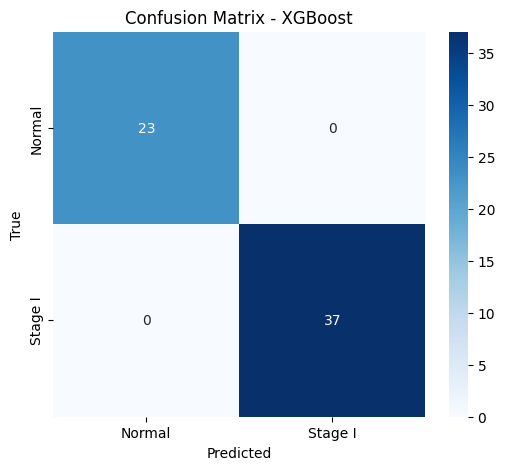

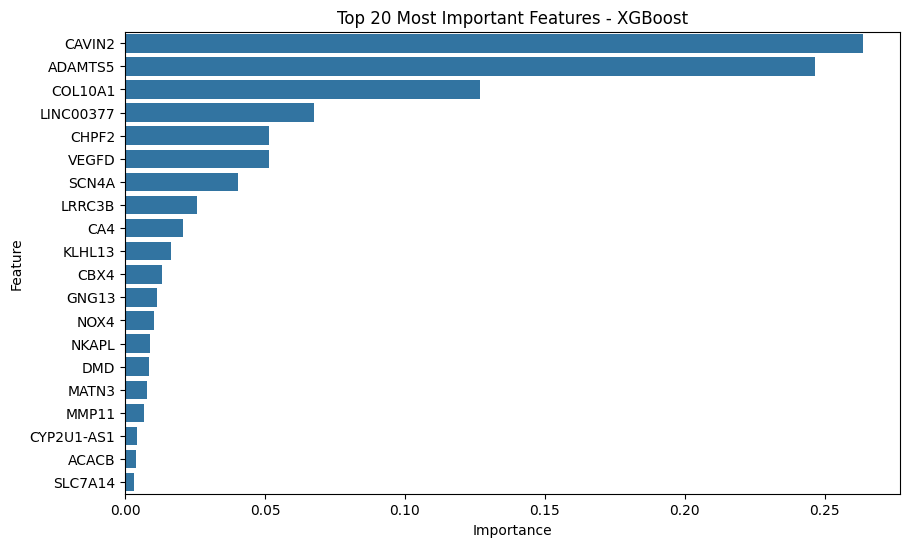

In [51]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test_rf_1, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances_xgb = xgb_model.feature_importances_
importance_df_xgb = pd.DataFrame({'Feature': X_train_rf_1.columns, 'Importance': feature_importances_xgb})
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb.head(20))
plt.title("Top 20 Most Important Features - XGBoost")
plt.show()


In [58]:
importance_df_xgb.to_csv("xgb_only_features.csv")

### DGE

In [71]:
merge_df

,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,paper_CNV.Clusters,paper_Mutation.Clusters,paper_DNA.Methylation.Clusters,paper_mRNA.Clusters,paper_miRNA.Clusters,paper_lncRNA.Clusters,paper_Protein.Clusters,paper_PARADIGM.Clusters,paper_Pan.Gyn.Clusters,combined_stage
TCGA-5L-AAT0-01A,11.491352,2.584963,9.843921,9.409391,7.924813,8.519636,10.756556,10.104599,9.638436,10.503826,...,C1,C9,C1,C2,C2,Unknown,Unknown,C6,Unknown,Stage II
TCGA-A2-A04U-01A,12.211888,4.392317,11.840778,8.942515,7.918863,7.129283,9.264443,10.397675,9.569856,11.050529,...,C6,C1,C4,C4,C7,C2,C5,C2,C5,Stage II
TCGA-AN-A04A-01A,10.469642,3.321928,10.953469,10.262095,8.154818,7.754888,11.971903,11.427313,9.766529,10.605480,...,C6,C1,C1,C1,C3,C2,C1,C5,C5,Stage III
TCGA-A7-A13D-01A,11.559855,0.000000,11.460456,9.209453,10.082149,7.857981,10.546894,11.319108,9.843921,11.357552,...,C4,C1,C4,C4,C7,C2,C5,C2,C5,Stage II
TCGA-A7-A13D-01A,11.559855,0.000000,11.460456,9.209453,10.082149,7.857981,10.546894,11.319108,9.843921,11.357552,...,C4,C1,C4,C4,C7,C2,C5,C2,C5,Stage II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A2-A1FV-01A,11.095397,6.228819,10.903129,12.233020,10.370687,7.658211,11.507795,11.199059,11.500842,12.337343,...,C5,C4,C2,C1,C2,C2,C2,C5,C5,Stage II
TCGA-C8-A275-01A,11.479275,3.459432,11.549303,11.979425,10.483816,10.858758,12.282220,11.320236,11.163650,11.841171,...,C6,C9,C2,C2,C2,C1,C1,C4,C3,Stage II
TCGA-A2-A0CS-01A,11.006326,3.321928,10.871905,10.140830,8.807355,8.285402,11.000704,11.012625,10.671541,10.720244,...,C1,C3,C1,C1,C3,C2,C1,C5,C1,Stage IV
TCGA-AR-A0TU-01A,13.126704,3.459432,11.356452,10.817783,11.198445,10.037547,9.525521,10.786270,11.881496,11.963980,...,Unknown,C1,C4,C4,Unknown,C2,C5,Unknown,C3,Stage II


In [119]:
def perform_wilcoxon_test(X, y, group1, group2):
    # Subset the data based on group labels
    X_group1 = X[y == group1]
    X_group2 = X[y == group2]
    
    combined_metrics = []
    p_values = []
    log_fold_changes = []
    i=0
    for feature in X.columns:
        i+=1
        if i%1000==0:
            print(i)
        # Extract feature values for each group
        group1_feature = X_group1[feature].dropna()
        group2_feature = X_group2[feature].dropna()
        
        # Ensure there are valid data points for testing
        if len(group1_feature) > 0 and len(group2_feature) > 0:
            try:
                _, p_value = mannwhitneyu(group1_feature, group2_feature, alternative='two-sided')
                
                # Calculate means (these are already scalar values)
                mean_group1 = group1_feature.mean()
                mean_group2 = group2_feature.mean()
                
                # Calculate log fold change if means are greater than zero
                if mean_group1 > 0 and mean_group2 > 0:
                    log_fc = np.log2(mean_group1 / mean_group2)
                else:
                    log_fc = np.nan
                
                
                # Compute combined metric
                if np.isfinite(p_value) and np.isfinite(log_fc):
                    combined_metric = -np.log10(p_value) * np.sign(log_fc)
                else:
                    combined_metric = np.nan
                    
            except Exception:
                p_value, log_fc, combined_metric = np.nan, np.nan, np.nan
        else:
            p_value, log_fc, combined_metric = np.nan, np.nan, np.nan
        
        # Append results for this feature
        p_values.append(p_value)
        log_fold_changes.append(log_fc)
        combined_metrics.append(combined_metric)
    
    # Compile results into a DataFrame
    results = pd.DataFrame({
        'Feature': X.columns,
        'P-Value': p_values,
        'Log2FC': log_fold_changes,
        'Combined Metric': combined_metrics,
    }).dropna().sort_values(by='Combined Metric', ascending=False)
    
    return results

In [120]:
comparisons = [
    ('Stage I','Normal'),
    ('Stage II','Normal'),
]

results = {}

for group1, group2 in comparisons:
    print(f"Processing comparison: {group1} vs. {group2}")
   
    filtered_data = merge_df[merge_df['combined_stage'].isin([group1, group2])]
    X_filtered = filtered_data.iloc[:,0:43430]
    X_new = X_filtered.loc[:, (X_filtered != X_filtered.iloc[0]).any()]
    
    y_filtered = filtered_data['combined_stage']
    wil_results =perform_wilcoxon_test(X_new, y_filtered, group1, group2)

    results[f'{group1}_vs_{group2}'] = {
        'T-Test Results': wil_results
    }
stage1_vs_normal_results = results['Stage I_vs_Normal']
t_test_df = stage1_vs_normal_results['T-Test Results']

Processing comparison: Stage I vs. Normal
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
Processing comparison: Stage II vs. Normal
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000


In [122]:
stage1_vs_normal_results=t_test_df

In [123]:
stage2_vs_normal_results = results['Stage II_vs_Normal']

In [129]:
stage2_vs_normal_results=stage2_vs_normal_results['T-Test Results']

In [131]:
stage2_vs_normal=stage2_vs_normal_results

In [125]:
def thresh(df):
    logfc_threshold = 0.5
    pval_threshold = 0.05
    
    # Filter genes
    filtered_genes = df[
        (abs(df['Log2FC']) >= logfc_threshold) &  # Magnitude of log fold change
        (df['P-Value'] <= pval_threshold)       # Significance threshold
    ]
    return filtered_genes

In [126]:
stage1_vs_normal=thresh(stage1_vs_normal_results)

In [127]:
stage1_vs_normal

,Feature,P-Value,Log2FC,Combined Metric
2136,MMP11,1.407354e-46,0.784767,45.851597
5378,COL10A1,2.854515e-46,1.202454,45.544468
27061,LINC01614,2.599777e-44,1.811846,43.585064
477,IBSP,4.268821e-44,2.929455,43.369692
27903,LINC02257,1.373995e-43,2.971062,42.862015
...,...,...,...,...
16982,MME,2.952806e-45,-0.501019,-44.529765
10569,CD300LG,2.232562e-45,-0.994423,-44.651197
12312,CAVIN2,3.392347e-46,-0.621071,-45.469500
11494,VEGFD,1.807171e-46,-1.138695,-45.743001


In [132]:
stage2_vs_normal=thresh(stage2_vs_normal_results)

In [133]:
stage2_vs_normal

,Feature,P-Value,Log2FC,Combined Metric
2136,MMP11,4.744423e-62,0.767652,61.323817
4732,NEK2,1.614668e-60,0.851340,59.791917
5378,COL10A1,7.518021e-60,1.172904,59.123896
5915,PKMYT1,8.806676e-60,0.857515,59.055188
1897,KIF4A,6.897872e-59,0.709541,58.161285
...,...,...,...,...
24751,LRRC3B-AS1,3.303925e-64,-2.936410,-63.480970
30485,LINC01497,1.067334e-66,-2.620770,-65.971699
39803,LINC01028,9.997944e-68,-2.906365,-67.000089
26527,LINC00377,8.095412e-68,-2.454425,-67.091761


In [134]:
stage2_vs_normal.to_csv("stage2_vs_nor_sig_genes")

In [135]:
stage1_vs_normal.to_csv("stage1_vs_nor_sig_genes")

In [136]:
nor_1_sig = stage1_vs_normal['Feature'].tolist()

In [137]:
nor_2_sig = stage2_vs_normal['Feature'].tolist()

#### DGE + RF

In [138]:
X_sig_1 = X_rf_1.loc[:, nor_1_sig]

In [139]:
y_sig_1= rf_1_df["combined_stage"]

In [140]:
X_sig_1

,MMP11,COL10A1,LINC01614,IBSP,LINC02257,PKMYT1,NEK2,HSD17B6,UHRF1,GABRD,...,MAMDC2,TSLP,PGM5P3-AS1,CA4,CPA1,MME,CD300LG,CAVIN2,VEGFD,LINC00377
TCGA-BH-A201-01A,14.225735,13.844313,9.134426,6.475733,5.643856,9.049849,10.395534,8.754888,10.367415,8.169925,...,8.965784,7.098032,1.000000,4.807355,2.321928,11.737670,7.321928,8.266787,5.857981,0.000000
TCGA-BH-A0H6-01A,16.039369,14.481862,9.548822,4.643856,6.658211,9.707359,8.693487,8.607330,8.463524,8.000000,...,7.375039,4.700440,0.000000,3.169925,3.000000,10.113742,5.754888,7.199672,4.459432,0.000000
TCGA-A2-A04R-01A,15.330322,13.395400,9.052568,6.807355,6.209453,11.505315,11.365776,8.409391,11.047124,7.515700,...,8.960002,3.321928,1.000000,2.584963,0.000000,9.612868,5.285402,8.918863,5.554589,0.000000
TCGA-E2-A1IH-01A,14.716819,14.930044,10.559377,7.629357,6.658211,7.918863,9.794416,9.459432,9.566054,8.228819,...,7.900867,5.754888,3.584963,3.584963,2.000000,10.583083,6.189825,9.517669,4.906891,1.000000
TCGA-BH-A0EB-01A,15.970892,14.567897,7.876517,8.507795,6.169925,7.409391,9.438792,9.209453,9.280771,7.629357,...,7.820179,4.321928,0.000000,0.000000,0.000000,9.957102,3.169925,7.686501,2.321928,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A0HW-01A,12.478011,9.383704,5.000000,9.807355,2.000000,9.461479,9.782998,6.523562,10.019591,8.761551,...,6.965784,3.169925,1.000000,1.000000,0.000000,6.022368,1.584963,7.055282,4.700440,0.000000
TCGA-BH-A1EO-11A,9.588715,7.592457,5.643856,2.321928,0.000000,5.426265,6.044394,5.000000,6.303781,5.392317,...,12.695663,8.857981,7.392317,12.519882,7.906891,13.281640,14.176719,13.568431,12.249706,4.807355
TCGA-AC-A23H-11A,7.918863,5.426265,1.584963,0.000000,2.000000,4.459432,5.643856,4.906891,6.700440,4.954196,...,11.811375,8.103288,6.000000,8.714246,5.209453,14.943156,11.252074,12.348728,12.483564,5.087463
TCGA-GM-A2DH-01A,14.966190,11.520128,6.714246,8.199672,4.459432,10.072803,12.088457,9.066089,12.689343,7.076816,...,7.321928,3.321928,2.584963,3.169925,0.000000,9.098032,5.321928,7.807355,5.392317,1.584963


In [141]:
y_sig_1

TCGA-BH-A201-01A    1
TCGA-BH-A0H6-01A    1
TCGA-A2-A04R-01A    1
TCGA-E2-A1IH-01A    1
TCGA-BH-A0EB-01A    1
                   ..
TCGA-BH-A0HW-01A    1
TCGA-BH-A1EO-11A    0
TCGA-AC-A23H-11A    0
TCGA-GM-A2DH-01A    1
TCGA-AC-A8OR-01A    1
Name: combined_stage, Length: 297, dtype: int64

In [151]:
X_train_rf_1_s, X_test_rf_1_s, y_train_rf_1_s, y_test_rf_1_s = train_test_split(X_sig_1, y_sig_1, test_size=0.2, random_state=42, stratify=y_sig_1)

In [152]:
scaler = StandardScaler()
X_train_scaled_rf_1_s = scaler.fit_transform(X_train_rf_1_s)
X_test_scaled_rf_1_s = scaler.transform(X_test_rf_1_s)

In [153]:
rf_1_s = RandomForestClassifier(random_state=42)
rf_1_s.fit(X_train_scaled_rf_1_s, y_train_rf_1_s)
y_pred_rf_1_s = rf_1_s.predict(X_test_scaled_rf_1_s)
y_proba_rf_1_s = rf_1_s.predict_proba(X_test_scaled_rf_1_s)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_1_s, y_pred_rf_1_s))
print("ROC-AUC:", roc_auc_score(y_test_rf_1_s, y_proba_rf_1_s))
print("\nClassification Report:\n", classification_report(y_test_rf_1_s, y_pred_rf_1_s))

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



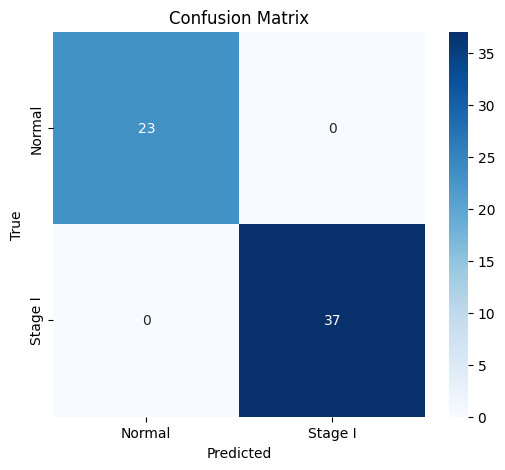

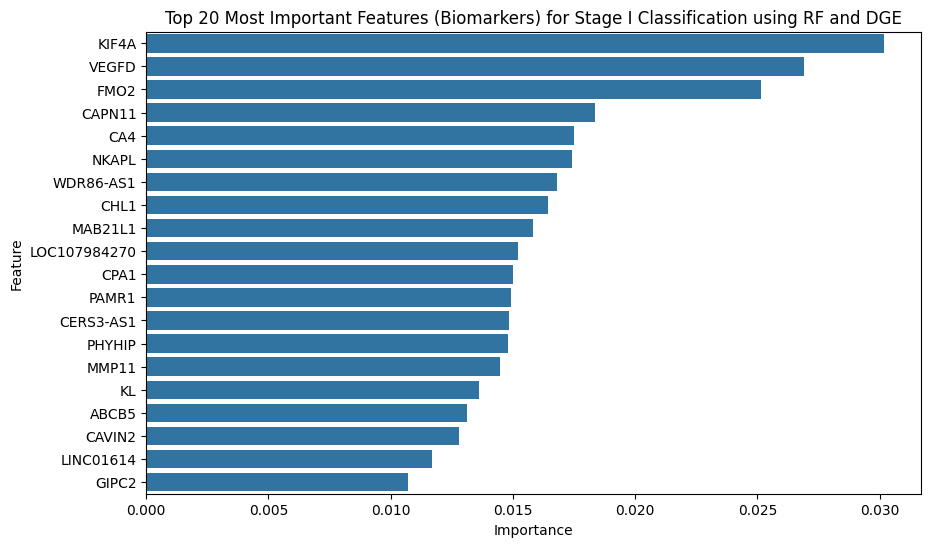

In [154]:
cm = confusion_matrix(y_test_rf_1_s, y_pred_rf_1_s)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

feature_importances = rf_1_s.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_1_s.columns,'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)



plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage I Classification using RF and DGE")
plt.show()

In [155]:
importance_df.to_csv("rf_dge_stage1_vs_nor.csv")

#### DGE + Gradient Boost

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



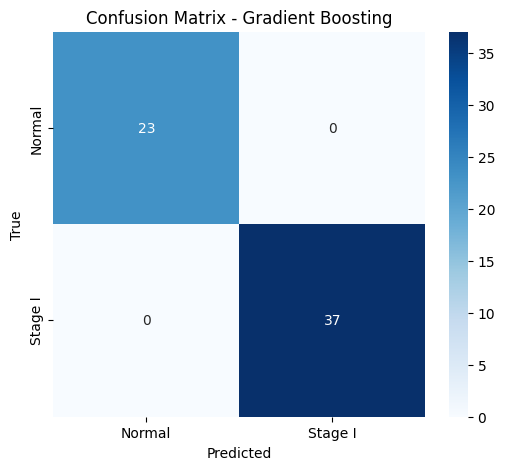

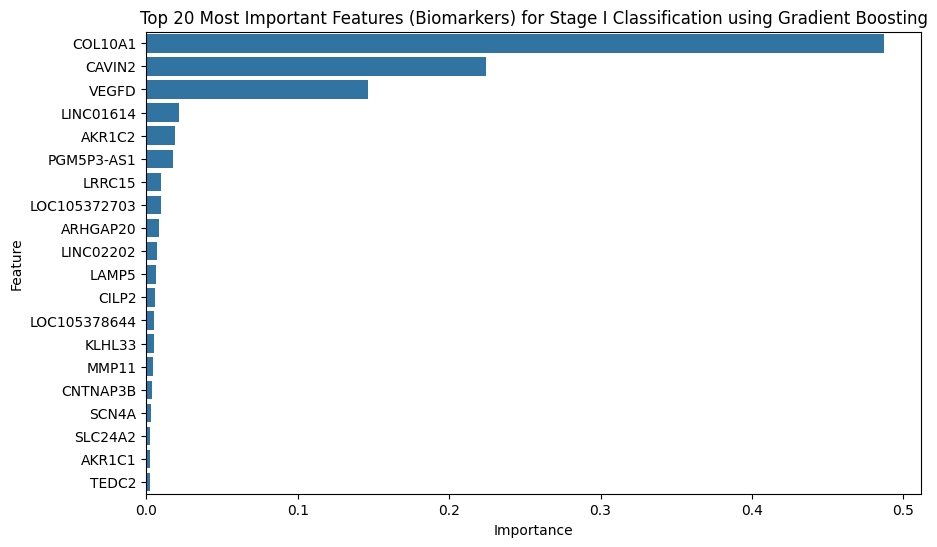

In [178]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_scaled_rf_1_s, y_train_rf_1_s)
y_pred_gbc = gbc.predict(X_test_scaled_rf_1_s)
y_proba_gbc = gbc.predict_proba(X_test_scaled_rf_1_s)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_1_s, y_pred_gbc))
print("ROC-AUC:", roc_auc_score(y_test_rf_1_s, y_proba_gbc))
print("\nClassification Report:\n", classification_report(y_test_rf_1_s, y_pred_gbc))

cm = confusion_matrix(y_test_rf_1_s, y_pred_gbc)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

feature_importances = gbc.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_1_s.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage I Classification using Gradient Boosting")
plt.show()


In [179]:
importance_df.to_csv("gb_dge_stage1_vs_nor.csv")

#### DGE + XGBoost

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



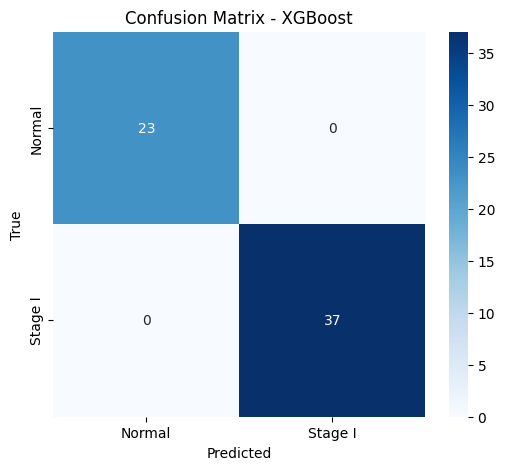

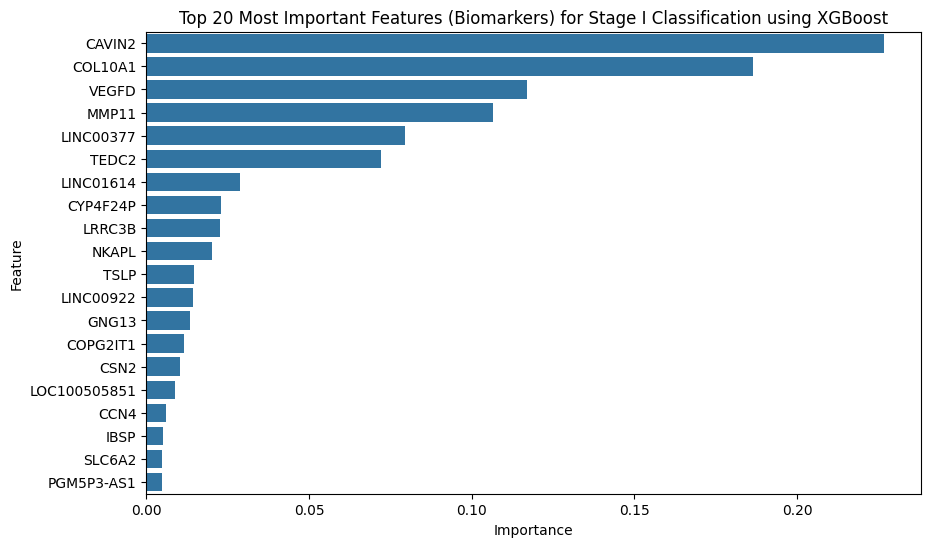

In [156]:
from xgboost import XGBClassifier

# XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled_rf_1_s, y_train_rf_1_s)
y_pred_xgb = xgb.predict(X_test_scaled_rf_1_s)
y_proba_xgb = xgb.predict_proba(X_test_scaled_rf_1_s)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_1_s, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test_rf_1_s, y_proba_xgb))
print("\nClassification Report:\n", classification_report(y_test_rf_1_s, y_pred_xgb))

cm = confusion_matrix(y_test_rf_1_s, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

feature_importances = xgb.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_1_s.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage I Classification using XGBoost")
plt.show()


In [157]:
importance_df.to_csv("xgb_dge_stage1_vs_nor.csv")

#### DGE + Logistic Regression

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



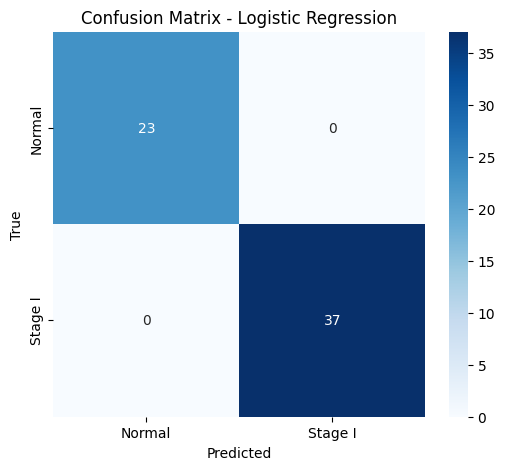

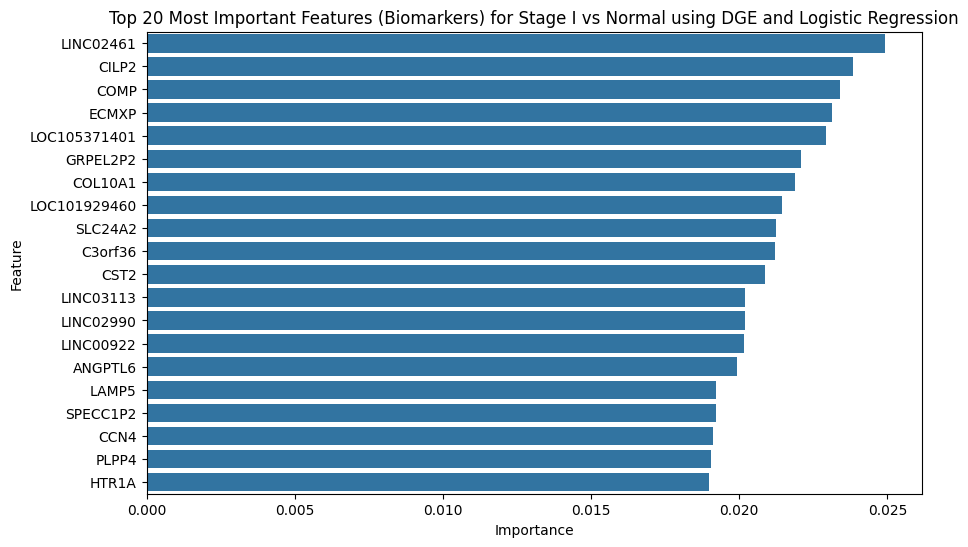

In [158]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled_rf_1_s, y_train_rf_1_s)
y_pred_logreg = logreg.predict(X_test_scaled_rf_1_s)
y_proba_logreg = logreg.predict_proba(X_test_scaled_rf_1_s)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_1_s, y_pred_logreg))
print("ROC-AUC:", roc_auc_score(y_test_rf_1_s, y_proba_logreg))
print("\nClassification Report:\n", classification_report(y_test_rf_1_s, y_pred_logreg))

cm = confusion_matrix(y_test_rf_1_s, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


feature_importances = abs(logreg.coef_[0])  # Taking absolute values of coefficients
importance_df = pd.DataFrame({'Feature': X_train_rf_1_s.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage I vs Normal using DGE and Logistic Regression")
plt.show()


In [159]:
importance_df.to_csv("logreg_dge_stage1_vs_nor.csv")

### SSGSEA 

#### RF

In [213]:
ssgsea_results = ssgsea(data=X_sig_1.T,  # Transpose: genes as rows
                        gene_sets=gene_set_file,
                        outdir="ssgsea_results",  # Specify the output directory
                        min_size=15,  # Minimum gene set size
                        max_size=500,  # Maximum gene set size
                        scale=True)  # Normalize the enrichment scores

2025-01-19 02:06:26,649 [WARNING] Found duplicated gene names, values averaged by gene names!


In [164]:
ssgsea_scores_1 = pd.read_csv("ssgsea_results/gseapy.gene_set.ssgsea.report.csv", index_col=0)

In [165]:
ssgsea_scores_1

,Term,ES,NES
Name,,,
TCGA-GI-A2C8-11A,HALLMARK_MYOGENESIS,3190.307217,1.036094
TCGA-A7-A0CH-11A,HALLMARK_KRAS_SIGNALING_UP,3017.498471,0.979972
TCGA-BH-A0E0-11A,HALLMARK_FATTY_ACID_METABOLISM,2924.437049,0.949749
TCGA-BH-A1FR-11B,HALLMARK_KRAS_SIGNALING_UP,2895.858556,0.940468
TCGA-D8-A1XM-01A,HALLMARK_KRAS_SIGNALING_UP,2877.918673,0.934642
...,...,...,...
TCGA-E2-A156-01A,HALLMARK_XENOBIOTIC_METABOLISM,400.295559,0.130001
TCGA-BH-A0EB-01A,HALLMARK_FATTY_ACID_METABOLISM,381.606206,0.123932
TCGA-BH-A0HN-01A,HALLMARK_FATTY_ACID_METABOLISM,316.180143,0.102684


In [167]:
ssgsea_pivoted_1 = ssgsea_scores_1.pivot_table(index='Name', columns='Term', values='NES')

In [168]:
final_1 = pd.merge(X_sig_1, ssgsea_pivoted_1,  how='left',left_on=None, right_on=None, left_index=True, right_index=True)

In [169]:
final_1

,MMP11,COL10A1,LINC01614,IBSP,LINC02257,PKMYT1,NEK2,HSD17B6,UHRF1,GABRD,...,LINC00377,HALLMARK_COAGULATION,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_GLYCOLYSIS,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_MYOGENESIS,HALLMARK_SPERMATOGENESIS,HALLMARK_XENOBIOTIC_METABOLISM
TCGA-BH-A201-01A,14.225735,13.844313,9.134426,6.475733,5.643856,9.049849,10.395534,8.754888,10.367415,8.169925,...,0.000000,0.674935,0.597805,0.626339,0.774382,0.571877,0.800903,0.568573,0.389147,0.583809
TCGA-BH-A0H6-01A,16.039369,14.481862,9.548822,4.643856,6.658211,9.707359,8.693487,8.607330,8.463524,8.000000,...,0.000000,0.367395,0.486530,0.707539,0.775137,0.587975,0.774616,0.640306,0.433849,0.404770
TCGA-A2-A04R-01A,15.330322,13.395400,9.052568,6.807355,6.209453,11.505315,11.365776,8.409391,11.047124,7.515700,...,0.000000,0.475429,0.579813,0.598593,0.492656,0.444737,0.787647,0.678909,0.411596,0.505462
TCGA-E2-A1IH-01A,14.716819,14.930044,10.559377,7.629357,6.658211,7.918863,9.794416,9.459432,9.566054,8.228819,...,1.000000,0.370551,0.511579,0.669488,0.909110,0.478905,0.882487,0.556583,0.457944,0.503843
TCGA-BH-A0EB-01A,15.970892,14.567897,7.876517,8.507795,6.169925,7.409391,9.438792,9.209453,9.280771,7.629357,...,0.000000,0.490093,0.123932,0.482229,0.533845,0.525589,0.712981,0.584910,0.448200,0.235778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A0HW-01A,12.478011,9.383704,5.000000,9.807355,2.000000,9.461479,9.782998,6.523562,10.019591,8.761551,...,0.000000,0.380671,0.322633,0.595972,0.398479,0.392418,0.748421,0.427217,0.413907,0.388640
TCGA-BH-A1EO-11A,9.588715,7.592457,5.643856,2.321928,0.000000,5.426265,6.044394,5.000000,6.303781,5.392317,...,4.807355,0.439062,0.730197,0.632101,0.895062,0.318448,0.852023,0.701965,0.571748,0.596617
TCGA-AC-A23H-11A,7.918863,5.426265,1.584963,0.000000,2.000000,4.459432,5.643856,4.906891,6.700440,4.954196,...,5.087463,0.480614,0.747961,0.631077,0.632372,0.511997,0.849152,0.672145,0.472406,0.600148
TCGA-GM-A2DH-01A,14.966190,11.520128,6.714246,8.199672,4.459432,10.072803,12.088457,9.066089,12.689343,7.076816,...,1.584963,0.441987,0.592700,0.648964,0.755121,0.615173,0.821889,0.637410,0.476208,0.574251


In [170]:
y_sig_1

TCGA-BH-A201-01A    1
TCGA-BH-A0H6-01A    1
TCGA-A2-A04R-01A    1
TCGA-E2-A1IH-01A    1
TCGA-BH-A0EB-01A    1
                   ..
TCGA-BH-A0HW-01A    1
TCGA-BH-A1EO-11A    0
TCGA-AC-A23H-11A    0
TCGA-GM-A2DH-01A    1
TCGA-AC-A8OR-01A    1
Name: combined_stage, Length: 297, dtype: int64

In [171]:
X_train_rf_1_ss, X_test_rf_1_ss, y_train_rf_1_ss, y_test_rf_1_ss = train_test_split(final_1, y_sig_1, test_size=0.2, random_state=42, stratify=y_sig_1)

In [172]:
scaler = StandardScaler()
X_train_scaled_rf_1_ss = scaler.fit_transform(X_train_rf_1_ss)
X_test_scaled_rf_1_ss= scaler.transform(X_test_rf_1_ss)

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



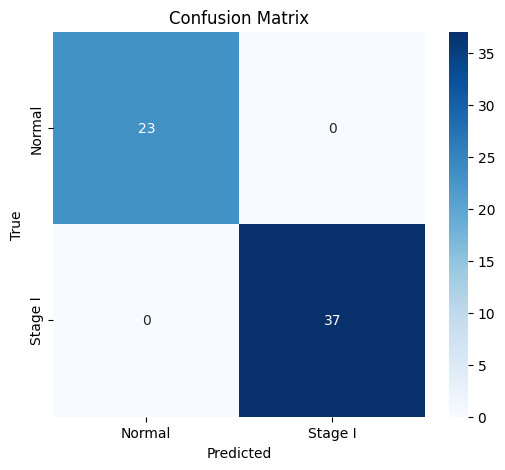

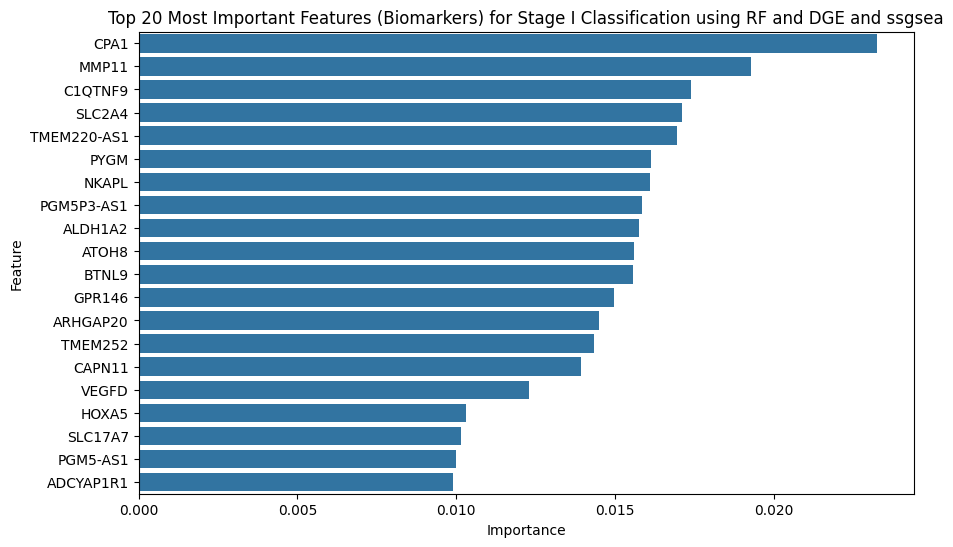

In [176]:
rf_1_ss = RandomForestClassifier(random_state=42)
rf_1_ss.fit(X_train_scaled_rf_1_ss, y_train_rf_1_ss)
y_pred_rf_1_ss = rf_1_ss.predict(X_test_scaled_rf_1_ss)
y_proba_rf_1_ss = rf_1_ss.predict_proba(X_test_scaled_rf_1_ss)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_1_ss, y_pred_rf_1_ss))
print("ROC-AUC:", roc_auc_score(y_test_rf_1_ss, y_proba_rf_1_ss))
print("\nClassification Report:\n", classification_report(y_test_rf_1_ss, y_pred_rf_1_ss))

cm = confusion_matrix(y_test_rf_1_ss, y_pred_rf_1_ss)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

feature_importances = rf_1_ss.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_1_ss.columns,'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)



plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage I Classification using RF and DGE and ssgsea")
plt.show()

In [177]:
importance_df.to_csv("rf_dge_ssgsea_stage1_vs_nor.csv")

#### Gradient Boost

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



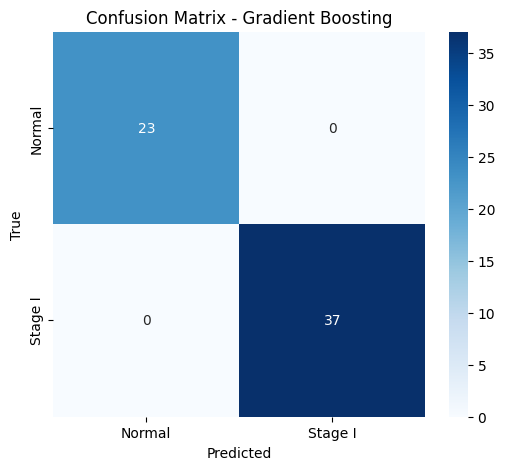

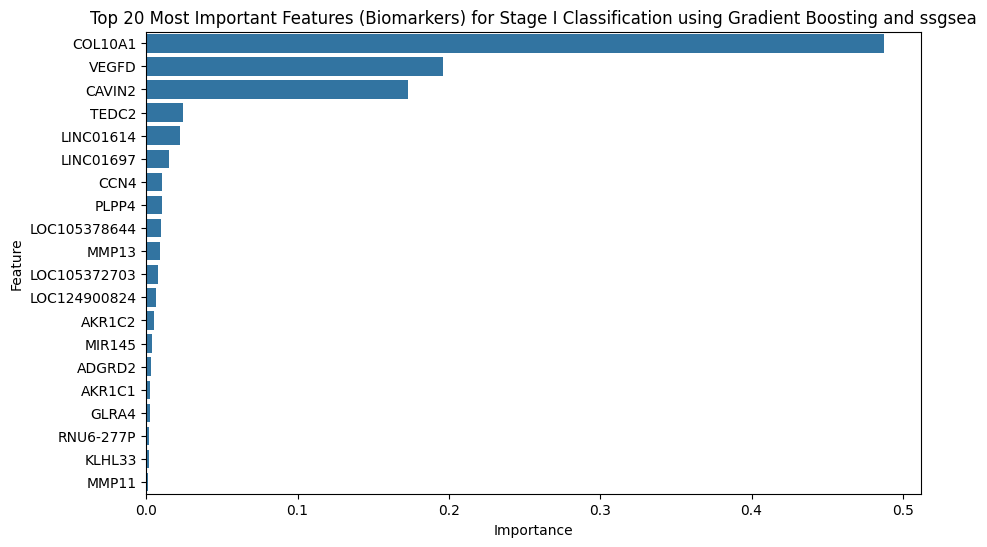

In [180]:
from sklearn.ensemble import GradientBoostingClassifier

# Training and Prediction
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_scaled_rf_1_ss, y_train_rf_1_ss)
y_pred_gbc = gbc.predict(X_test_scaled_rf_1_ss)
y_proba_gbc = gbc.predict_proba(X_test_scaled_rf_1_ss)[:, 1]

# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test_rf_1_ss, y_pred_gbc))
print("ROC-AUC:", roc_auc_score(y_test_rf_1_ss, y_proba_gbc))
print("\nClassification Report:\n", classification_report(y_test_rf_1_ss, y_pred_gbc))

# Confusion Matrix
cm = confusion_matrix(y_test_rf_1_ss, y_pred_gbc)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances = gbc.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_1_ss.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage I Classification using Gradient Boosting and ssgsea")
plt.show()


In [181]:
importance_df.to_csv("gb_dge_ssgsea_stage1_vs_nor.csv")

#### XGBoost

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



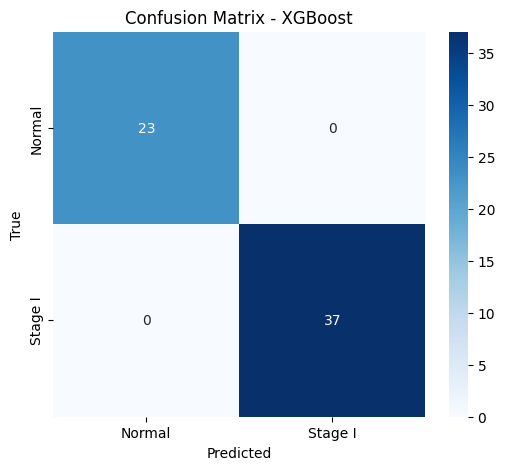

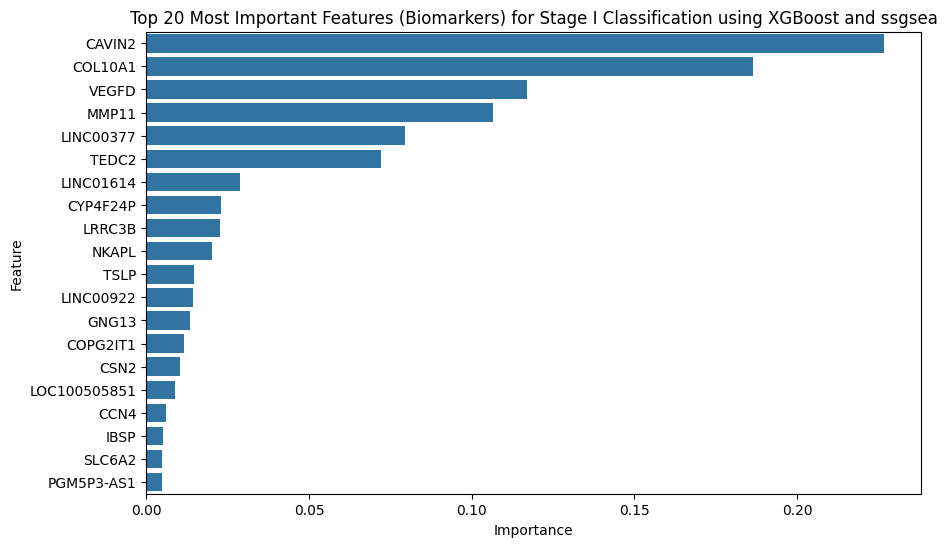

In [182]:
from xgboost import XGBClassifier

# Training and Prediction
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_scaled_rf_1_ss, y_train_rf_1_ss)
y_pred_xgb = xgb.predict(X_test_scaled_rf_1_ss)
y_proba_xgb = xgb.predict_proba(X_test_scaled_rf_1_ss)[:, 1]

# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test_rf_1_ss, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test_rf_1_ss, y_proba_xgb))
print("\nClassification Report:\n", classification_report(y_test_rf_1_ss, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test_rf_1_ss, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances = xgb.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_1_ss.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage I Classification using XGBoost and ssgsea")
plt.show()


In [183]:
importance_df.to_csv("xgb_dge_ssgsea_stage1_vs_nor.csv")

#### Logistic Regression

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



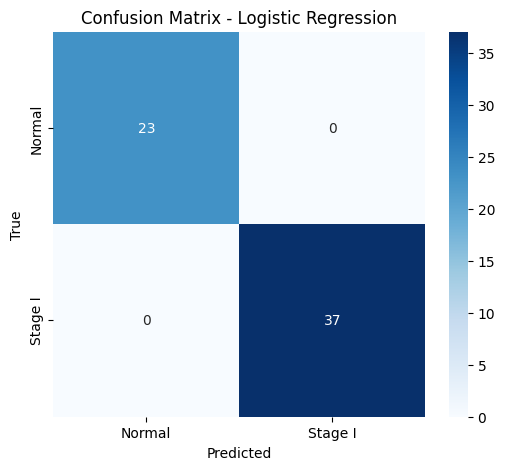

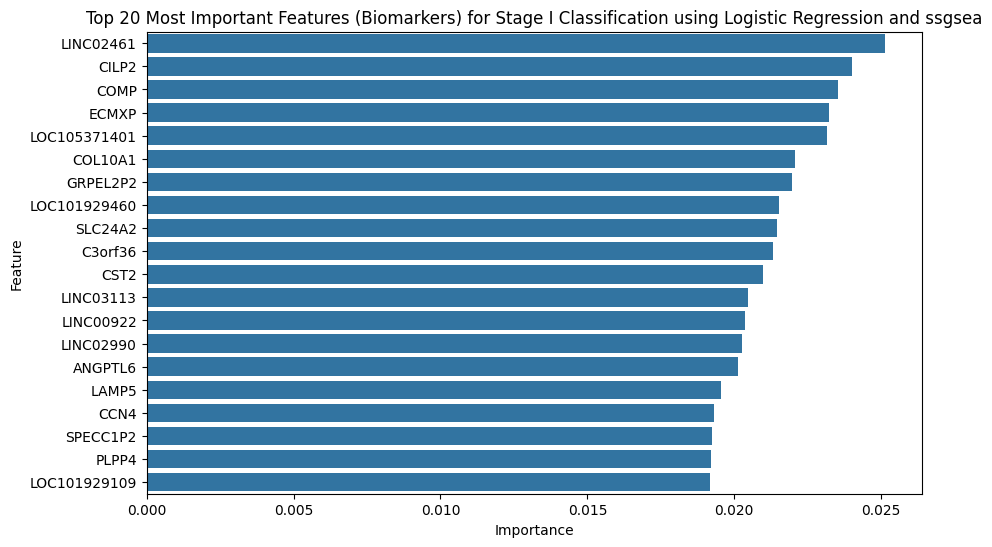

In [184]:
from sklearn.linear_model import LogisticRegression

# Training and Prediction
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled_rf_1_ss, y_train_rf_1_ss)
y_pred_logreg = logreg.predict(X_test_scaled_rf_1_ss)
y_proba_logreg = logreg.predict_proba(X_test_scaled_rf_1_ss)[:, 1]

# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test_rf_1_ss, y_pred_logreg))
print("ROC-AUC:", roc_auc_score(y_test_rf_1_ss, y_proba_logreg))
print("\nClassification Report:\n", classification_report(y_test_rf_1_ss, y_pred_logreg))

# Confusion Matrix
cm = confusion_matrix(y_test_rf_1_ss, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance (Coefficients)
feature_importances = abs(logreg.coef_[0])  # Absolute value of coefficients
importance_df = pd.DataFrame({'Feature': X_train_rf_1_ss.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage I Classification using Logistic Regression and ssgsea")
plt.show()


In [185]:
importance_df.to_csv("logreg_dge_ssgsea_stage1_vs_nor.csv")

## Normal vs stage 2

### Only

#### RF

In [187]:
rf_2_df= merge_df[merge_df["combined_stage"].isin(["Stage II", "Normal"])]

In [188]:
rf_2_df['combined_stage'] = rf_2_df['combined_stage'].map({'Normal': 0, 'Stage II': 1})

C:\Users\Neermita Bhattachary\AppData\Local\Temp\ipykernel_22704\203363913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_2_df['combined_stage'] = rf_2_df['combined_stage'].map({'Normal': 0, 'Stage II': 1})


In [189]:
X_rf_2= rf_2_df.iloc[:, 0:43430]

In [190]:
y_rf_2= rf_2_df["combined_stage"]

In [191]:
X_train_rf_2, X_test_rf_2, y_train_rf_2, y_test_rf_2 = train_test_split(X_rf_2, y_rf_2, test_size=0.2, random_state=42, stratify=y_rf_2)

In [192]:
X_train_scaled_rf_2 = scaler.fit_transform(X_train_rf_2)
X_test_scaled_rf_2= scaler.transform(X_test_rf_2)

In [193]:
rf_2 = RandomForestClassifier(random_state=42)
rf_2.fit(X_train_scaled_rf_2, y_train_rf_2)
y_pred_rf_2 = rf_2.predict(X_test_scaled_rf_2)
y_proba_rf_2 = rf_2.predict_proba(X_test_scaled_rf_2)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_2, y_pred_rf_2))
print("ROC-AUC:", roc_auc_score(y_test_rf_2, y_proba_rf_2))
print("\nClassification Report:\n", classification_report(y_test_rf_2, y_pred_rf_2))

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       127

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



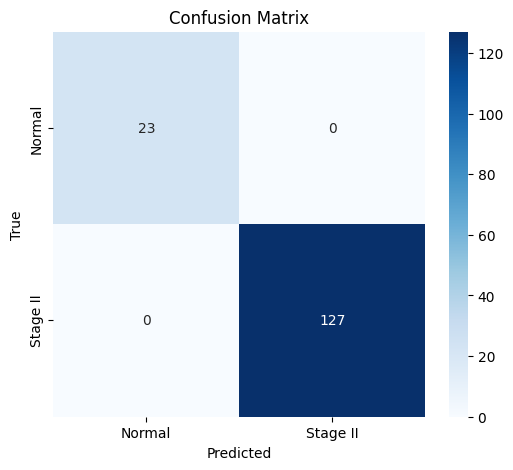

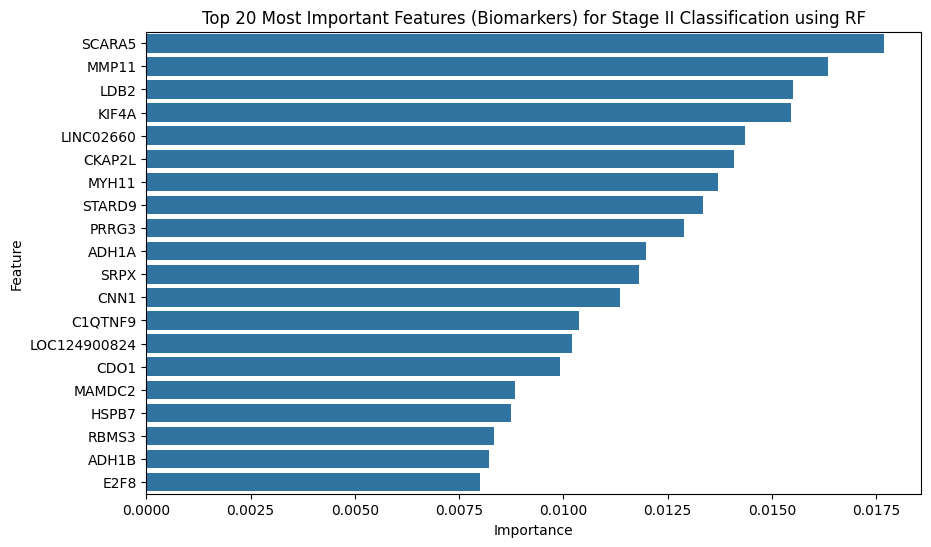

In [194]:
cm = confusion_matrix(y_test_rf_2, y_pred_rf_2)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

feature_importances = rf_2.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_2.columns,'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)



plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using RF")
plt.show()

In [195]:
importance_df.to_csv("rf_only_stage2_vs_nor.csv")

#### Gradient Boost

Accuracy: 0.98
ROC-AUC: 0.953782951044163

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.98      0.99      0.99       127

    accuracy                           0.98       150
   macro avg       0.97      0.95      0.96       150
weighted avg       0.98      0.98      0.98       150



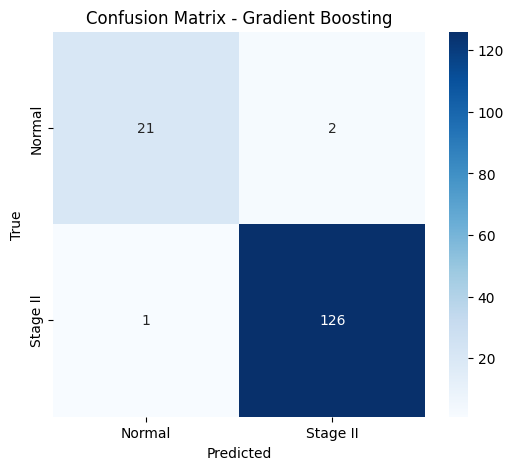

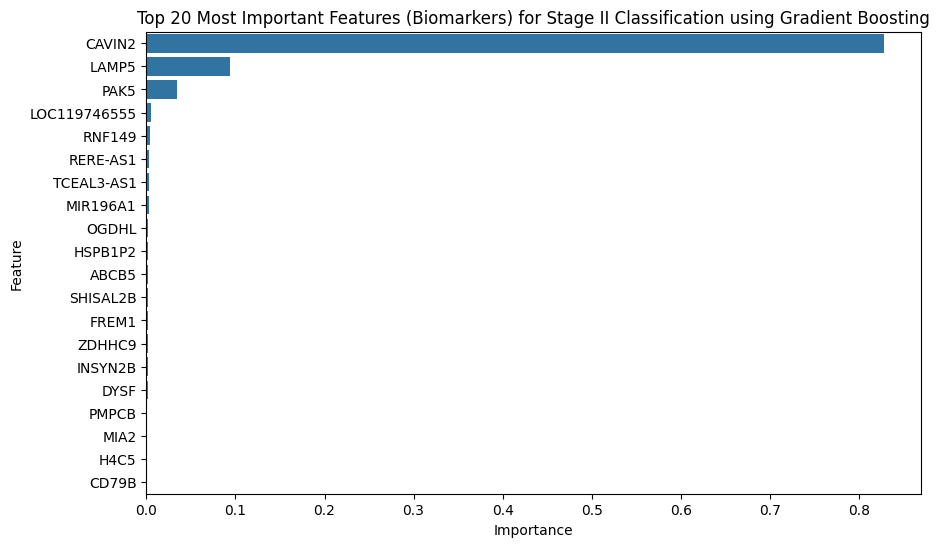

In [199]:
from sklearn.ensemble import GradientBoostingClassifier

# Training and Prediction
gbc_2 = GradientBoostingClassifier(random_state=42)
gbc_2.fit(X_train_scaled_rf_2, y_train_rf_2)
y_pred_gbc_2 = gbc_2.predict(X_test_scaled_rf_2)
y_proba_gbc_2 = gbc_2.predict_proba(X_test_scaled_rf_2)[:, 1]

# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test_rf_2, y_pred_gbc_2))
print("ROC-AUC:", roc_auc_score(y_test_rf_2, y_proba_gbc_2))
print("\nClassification Report:\n", classification_report(y_test_rf_2, y_pred_gbc_2))

# Confusion Matrix
cm = confusion_matrix(y_test_rf_2, y_pred_gbc_2)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances = gbc_2.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_2.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using Gradient Boosting")
plt.show()

# Save Feature Importances
importance_df.to_csv("gb_only_stage2_vs_nor.csv")


#### Logistic Regression

Accuracy: 0.98
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        23
           1       1.00      0.98      0.99       127

    accuracy                           0.98       150
   macro avg       0.94      0.99      0.96       150
weighted avg       0.98      0.98      0.98       150



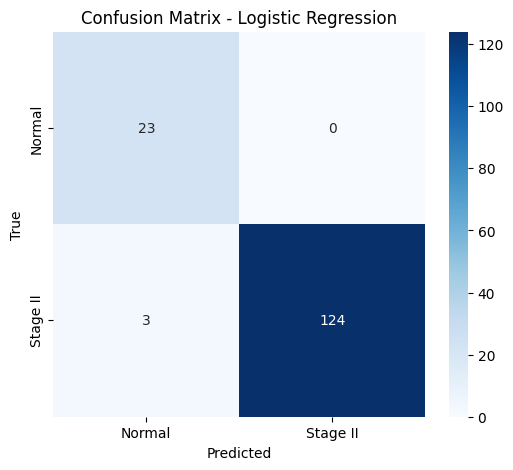

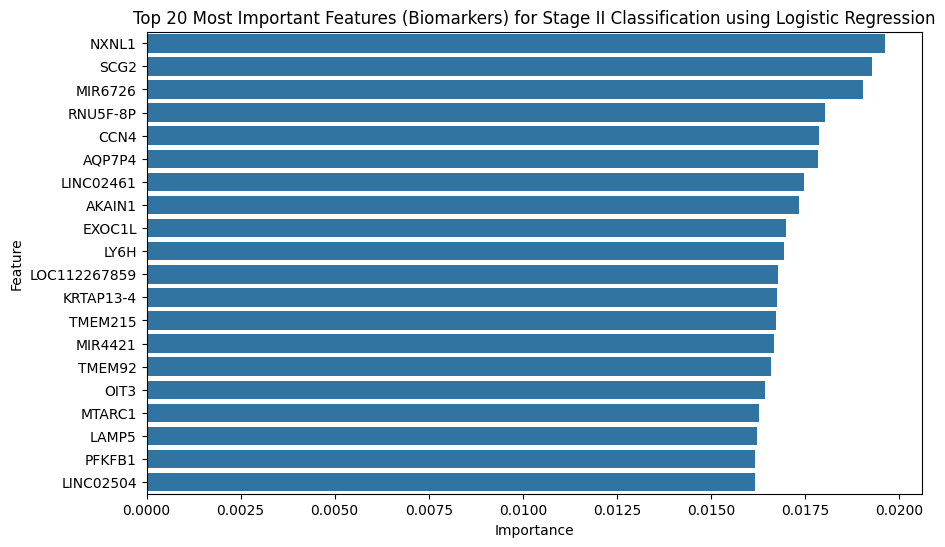

In [198]:
from sklearn.linear_model import LogisticRegression

# Training and Prediction
logreg_2 = LogisticRegression(random_state=42, max_iter=1000)
logreg_2.fit(X_train_scaled_rf_2, y_train_rf_2)
y_pred_logreg_2 = logreg_2.predict(X_test_scaled_rf_2)
y_proba_logreg_2 = logreg_2.predict_proba(X_test_scaled_rf_2)[:, 1]

# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test_rf_2, y_pred_logreg_2))
print("ROC-AUC:", roc_auc_score(y_test_rf_2, y_proba_logreg_2))
print("\nClassification Report:\n", classification_report(y_test_rf_2, y_pred_logreg_2))

# Confusion Matrix
cm = confusion_matrix(y_test_rf_2, y_pred_logreg_2)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances = abs(logreg_2.coef_[0])  # Absolute value of coefficients
importance_df = pd.DataFrame({'Feature': X_train_rf_2.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using Logistic Regression")
plt.show()

# Save Feature Importances
importance_df.to_csv("logreg_only_stage2_vs_nor.csv")


#### XGBoost

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       127

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



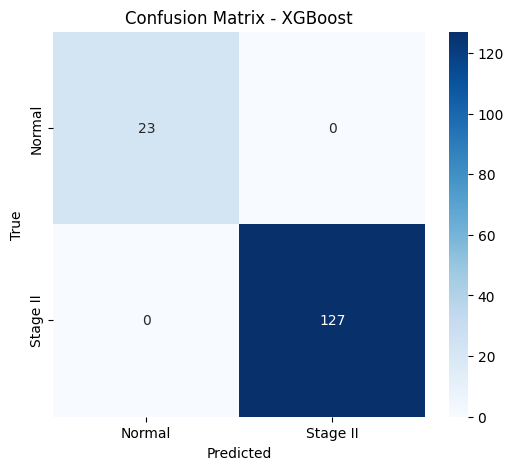

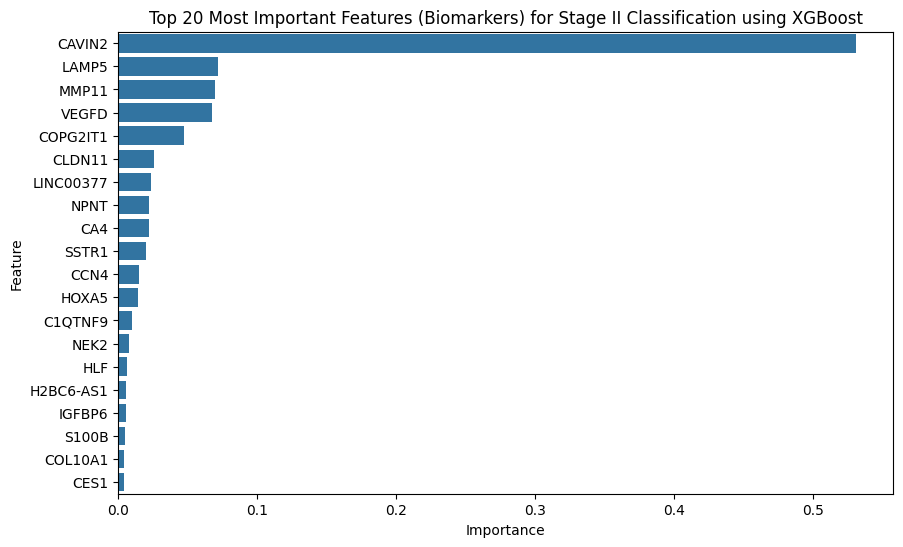

In [197]:
from xgboost import XGBClassifier

# Training and Prediction
xgb_2 = XGBClassifier(random_state=42)
xgb_2.fit(X_train_scaled_rf_2, y_train_rf_2)
y_pred_xgb_2 = xgb_2.predict(X_test_scaled_rf_2)
y_proba_xgb_2 = xgb_2.predict_proba(X_test_scaled_rf_2)[:, 1]

# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test_rf_2, y_pred_xgb_2))
print("ROC-AUC:", roc_auc_score(y_test_rf_2, y_proba_xgb_2))
print("\nClassification Report:\n", classification_report(y_test_rf_2, y_pred_xgb_2))

# Confusion Matrix
cm = confusion_matrix(y_test_rf_2, y_pred_xgb_2)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances = xgb_2.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_2.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using XGBoost")
plt.show()

# Save Feature Importances
importance_df.to_csv("xgb_only_stage2_vs_nor.csv")


### DGE

#### DGE + RF

In [200]:
X_sig_2 = X_rf_2.loc[:, nor_2_sig]

In [201]:
y_sig_2= rf_2_df["combined_stage"]

In [202]:
y_sig_2

TCGA-5L-AAT0-01A    1
TCGA-A2-A04U-01A    1
TCGA-A7-A13D-01A    1
TCGA-A7-A13D-01A    1
TCGA-AN-A03X-01A    1
                   ..
TCGA-A8-A07O-01A    1
TCGA-A2-A1FV-01A    1
TCGA-C8-A275-01A    1
TCGA-AR-A0TU-01A    1
TCGA-B6-A401-01A    1
Name: combined_stage, Length: 749, dtype: int64

In [203]:
X_train_rf_2_s, X_test_rf_2_s, y_train_rf_2_s, y_test_rf_2_s = train_test_split(X_sig_2, y_sig_2, test_size=0.2, random_state=42, stratify=y_sig_2)

In [204]:
scaler = StandardScaler()
X_train_scaled_rf_2_s = scaler.fit_transform(X_train_rf_2_s)
X_test_scaled_rf_2_s = scaler.transform(X_test_rf_2_s)

In [206]:
rf_2_s = RandomForestClassifier(random_state=42)
rf_2_s.fit(X_train_scaled_rf_2_s, y_train_rf_2_s)
y_pred_rf_2_s = rf_2_s.predict(X_test_scaled_rf_2_s)
y_proba_rf_2_s = rf_2_s.predict_proba(X_test_scaled_rf_2_s)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_2_s, y_pred_rf_2_s))
print("ROC-AUC:", roc_auc_score(y_test_rf_2_s, y_proba_rf_2_s))
print("\nClassification Report:\n", classification_report(y_test_rf_2_s, y_pred_rf_2_s))

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       127

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



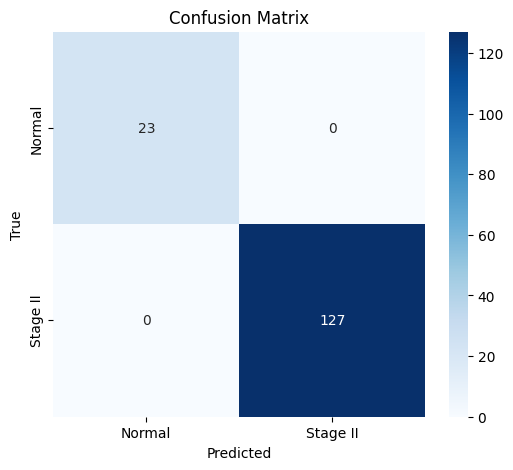

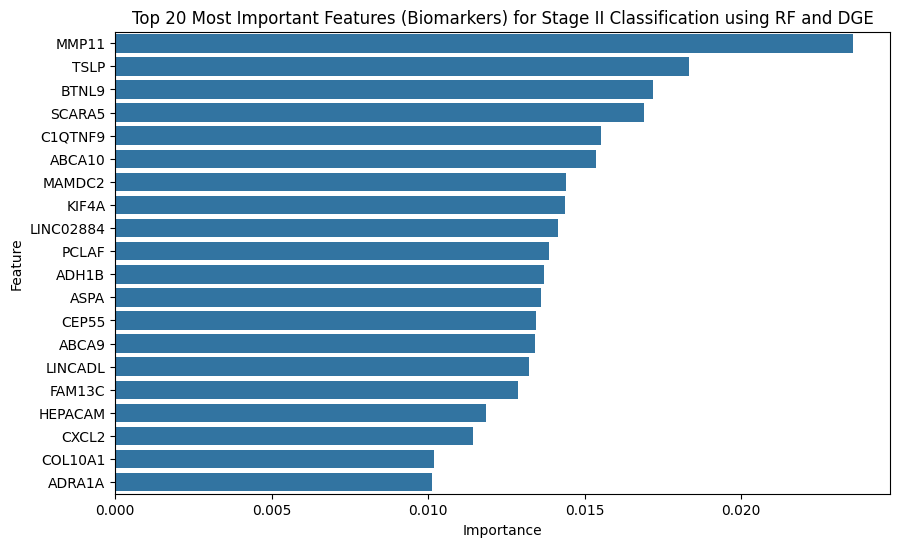

In [207]:
cm = confusion_matrix(y_test_rf_2_s, y_pred_rf_2_s)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

feature_importances = rf_2_s.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_2_s.columns,'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)



plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using RF and DGE")
plt.show()

importance_df.to_csv("rf_dge_stage2_vs_nor.csv")

#### DGE + Gradient Boost

Accuracy: 0.98
ROC-AUC: 0.9548099965765149

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.98      0.99      0.99       127

    accuracy                           0.98       150
   macro avg       0.97      0.95      0.96       150
weighted avg       0.98      0.98      0.98       150



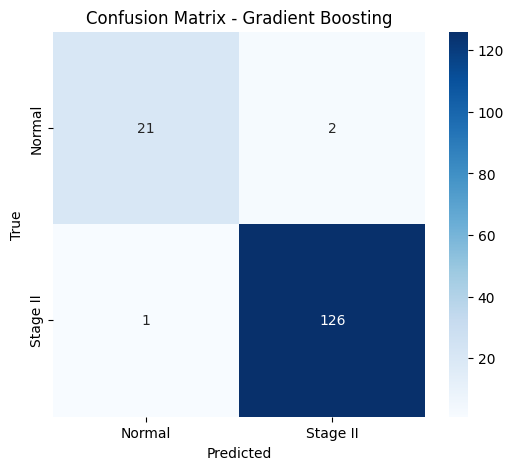

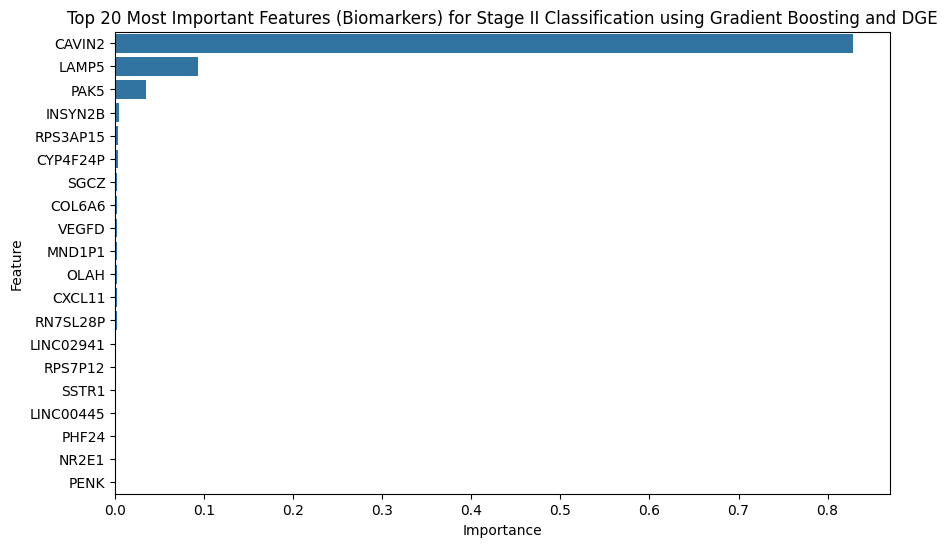

In [208]:
from sklearn.ensemble import GradientBoostingClassifier

# Training and Prediction
gbc_2_s = GradientBoostingClassifier(random_state=42)
gbc_2_s.fit(X_train_scaled_rf_2_s, y_train_rf_2_s)
y_pred_gbc_2_s = gbc_2_s.predict(X_test_scaled_rf_2_s)
y_proba_gbc_2_s = gbc_2_s.predict_proba(X_test_scaled_rf_2_s)[:, 1]

# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test_rf_2_s, y_pred_gbc_2_s))
print("ROC-AUC:", roc_auc_score(y_test_rf_2_s, y_proba_gbc_2_s))
print("\nClassification Report:\n", classification_report(y_test_rf_2_s, y_pred_gbc_2_s))

# Confusion Matrix
cm = confusion_matrix(y_test_rf_2_s, y_pred_gbc_2_s)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances = gbc_2_s.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_2_s.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using Gradient Boosting and DGE")
plt.show()

# Save Feature Importances
importance_df.to_csv("gb_dge_stage2_vs_nor.csv")


#### DGE + XGBoost

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:59:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       127

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



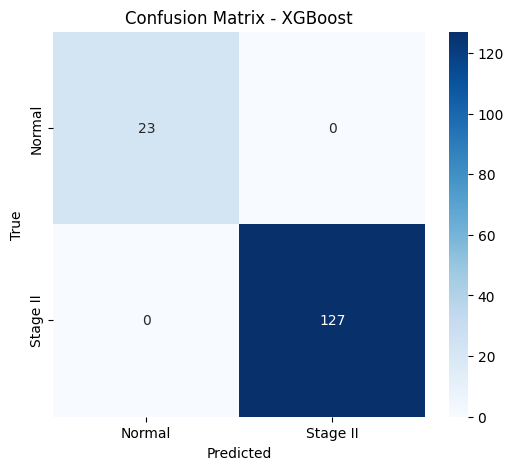

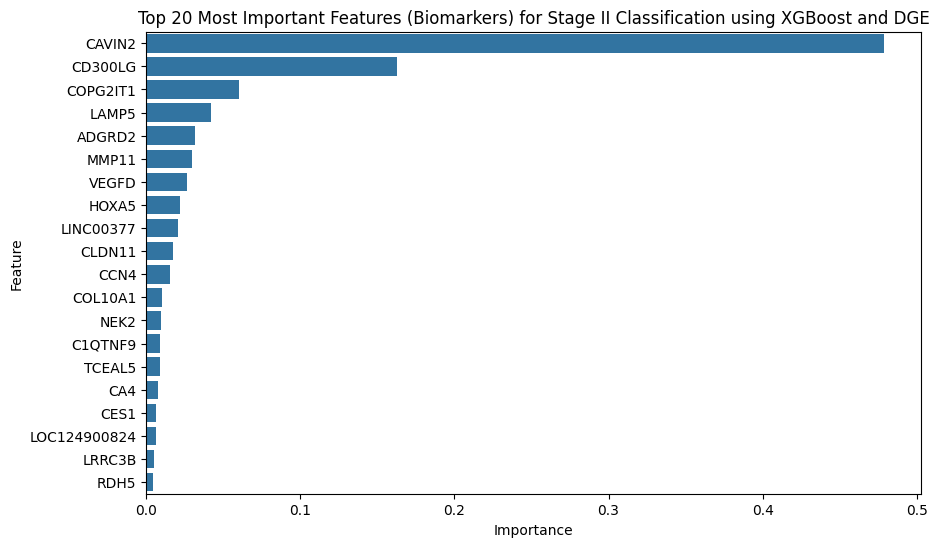

In [209]:
from xgboost import XGBClassifier

# Training and Prediction
xgb_2_s = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_2_s.fit(X_train_scaled_rf_2_s, y_train_rf_2_s)
y_pred_xgb_2_s = xgb_2_s.predict(X_test_scaled_rf_2_s)
y_proba_xgb_2_s = xgb_2_s.predict_proba(X_test_scaled_rf_2_s)[:, 1]

# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test_rf_2_s, y_pred_xgb_2_s))
print("ROC-AUC:", roc_auc_score(y_test_rf_2_s, y_proba_xgb_2_s))
print("\nClassification Report:\n", classification_report(y_test_rf_2_s, y_pred_xgb_2_s))

# Confusion Matrix
cm = confusion_matrix(y_test_rf_2_s, y_pred_xgb_2_s)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances = xgb_2_s.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_2_s.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using XGBoost and DGE")
plt.show()

# Save Feature Importances
importance_df.to_csv("xgb_dge_stage2_vs_nor.csv")


#### DGE + Logisitic regression

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       127

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



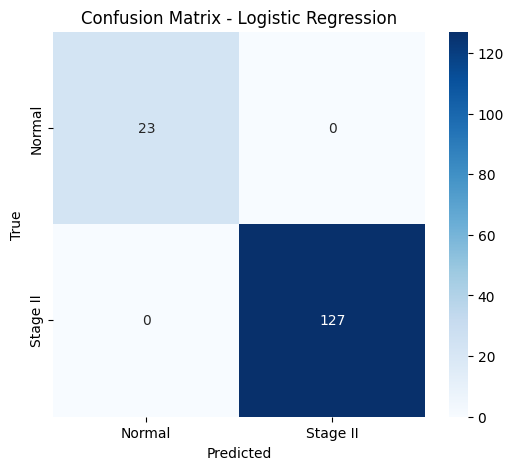

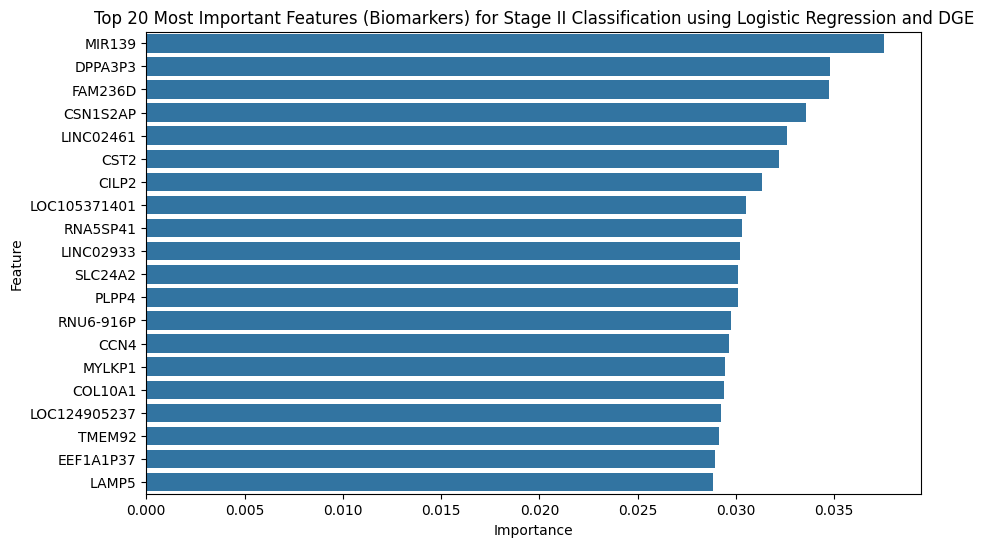

In [211]:
from sklearn.linear_model import LogisticRegression

# Training and Prediction
logreg_2_s = LogisticRegression(random_state=42, max_iter=1000)
logreg_2_s.fit(X_train_scaled_rf_2_s, y_train_rf_2_s)
y_pred_logreg_2_s = logreg_2_s.predict(X_test_scaled_rf_2_s)
y_proba_logreg_2_s = logreg_2_s.predict_proba(X_test_scaled_rf_2_s)[:, 1]

# Evaluation Metrics
print("Accuracy:", accuracy_score(y_test_rf_2_s, y_pred_logreg_2_s))
print("ROC-AUC:", roc_auc_score(y_test_rf_2_s, y_proba_logreg_2_s))
print("\nClassification Report:\n", classification_report(y_test_rf_2_s, y_pred_logreg_2_s))

# Confusion Matrix
cm = confusion_matrix(y_test_rf_2_s, y_pred_logreg_2_s)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
feature_importances = abs(logreg_2_s.coef_[0])  # Absolute value of coefficients
importance_df = pd.DataFrame({'Feature': X_train_rf_2_s.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using Logistic Regression and DGE")
plt.show()

# Save Feature Importances
importance_df.to_csv("logreg_dge_stage2_vs_nor.csv")


### SSGSEA

#### RF

In [216]:
X_sig_2 = X_sig_2.reset_index()
X_sig_2.index = X_sig_2.index.map(str) 

In [218]:
ssgsea_results = ssgsea(data=X_sig_2.T,  # Transpose: genes as rows
                        gene_sets=gene_set_file,
                        outdir="ssgsea_results",  # Specify the output directory
                        min_size=15,  # Minimum gene set size
                        max_size=500,  # Maximum gene set size
                        scale=True)  # Normalize the enrichment scores

In [219]:
ssgsea_scores_2 = pd.read_csv("ssgsea_results/gseapy.gene_set.ssgsea.report.csv", index_col=0)

In [220]:
ssgsea_pivoted_2= ssgsea_scores_2.pivot_table(index='Name', columns='Term', values='NES')

In [221]:
final_2 = pd.merge(X_sig_2, ssgsea_pivoted_2,  how='left',left_on=None, right_on=None, left_index=True, right_index=True)

In [227]:
final_2=final_2.set_index("index")

In [228]:
X_train_rf_2_ss, X_test_rf_2_ss, y_train_rf_2_ss, y_test_rf_2_ss = train_test_split(final_2, y_sig_2, test_size=0.2, random_state=42, stratify=y_sig_2)

In [230]:
scaler = StandardScaler()
X_train_scaled_rf_2_ss = scaler.fit_transform(X_train_rf_2_ss)
X_test_scaled_rf_2_ss= scaler.transform(X_test_rf_2_ss)

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       127

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



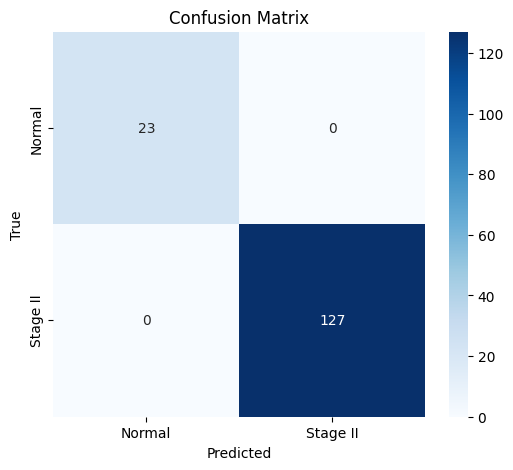

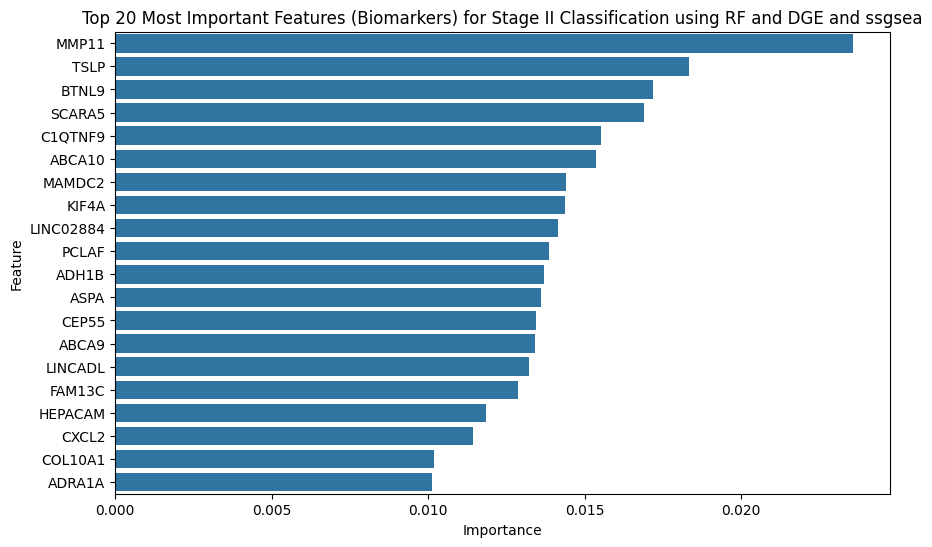

In [231]:
rf_2_ss = RandomForestClassifier(random_state=42)
rf_2_ss.fit(X_train_scaled_rf_2_ss, y_train_rf_2_ss)
y_pred_rf_2_ss = rf_2_ss.predict(X_test_scaled_rf_2_ss)
y_proba_rf_2_ss = rf_2_ss.predict_proba(X_test_scaled_rf_2_ss)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_2_ss, y_pred_rf_2_ss))
print("ROC-AUC:", roc_auc_score(y_test_rf_2_ss, y_proba_rf_2_ss))
print("\nClassification Report:\n", classification_report(y_test_rf_2_ss, y_pred_rf_2_ss))

cm = confusion_matrix(y_test_rf_2_ss, y_pred_rf_2_ss)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

feature_importances = rf_2_ss.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_2_ss.columns,'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)



plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using RF and DGE and ssgsea")
plt.show()

In [232]:
importance_df.to_csv("rf_dge_ssgsea_stage2_vs_normal.csv")

#### Gradient Boost

Accuracy: 0.98
ROC-AUC: 0.9548099965765149

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.98      0.99      0.99       127

    accuracy                           0.98       150
   macro avg       0.97      0.95      0.96       150
weighted avg       0.98      0.98      0.98       150



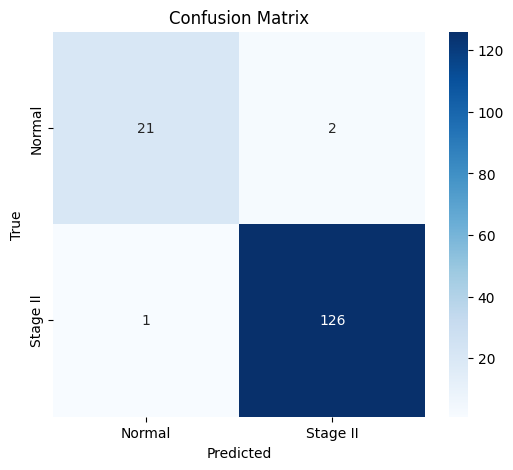

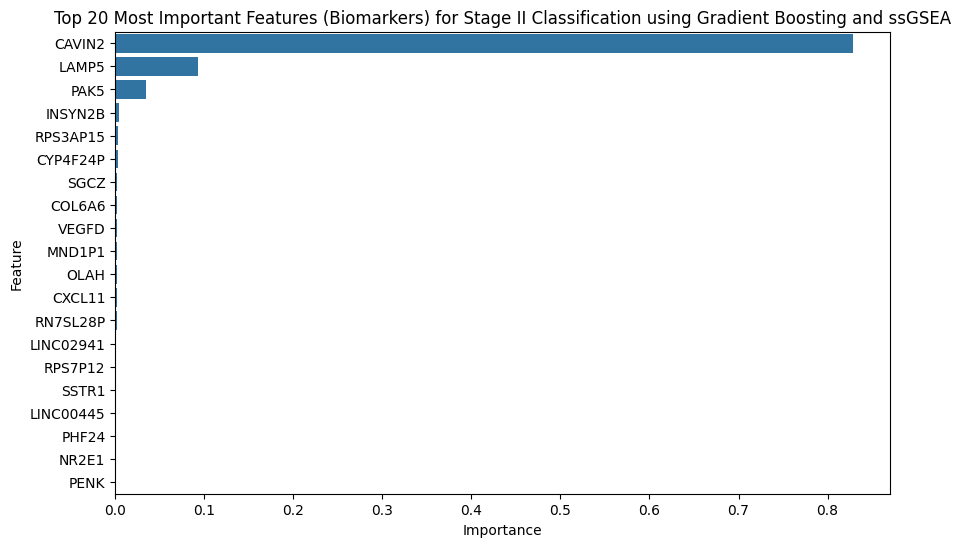

In [233]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
gb_2_ss = GradientBoostingClassifier(random_state=42)
gb_2_ss.fit(X_train_scaled_rf_2_ss, y_train_rf_2_ss)
y_pred_gb_2_ss = gb_2_ss.predict(X_test_scaled_rf_2_ss)
y_proba_gb_2_ss = gb_2_ss.predict_proba(X_test_scaled_rf_2_ss)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_2_ss, y_pred_gb_2_ss))
print("ROC-AUC:", roc_auc_score(y_test_rf_2_ss, y_proba_gb_2_ss))
print("\nClassification Report:\n", classification_report(y_test_rf_2_ss, y_pred_gb_2_ss))

cm = confusion_matrix(y_test_rf_2_ss, y_pred_gb_2_ss)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

feature_importances = gb_2_ss.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_2_ss.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using Gradient Boosting and ssGSEA")
plt.show()

importance_df.to_csv("gb_dge_ssgsea_stage2_vs_normal.csv")


#### XGBoost

C:\Users\Neermita Bhattachary\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       127

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



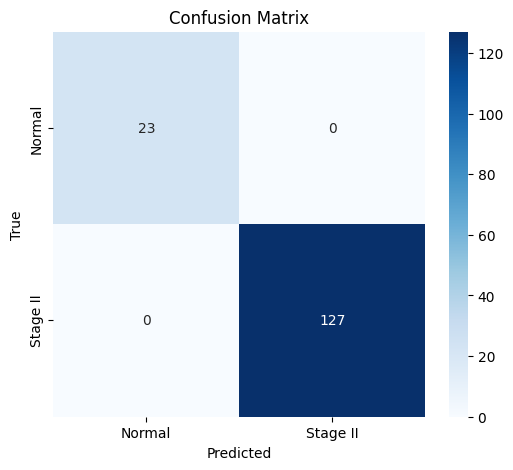

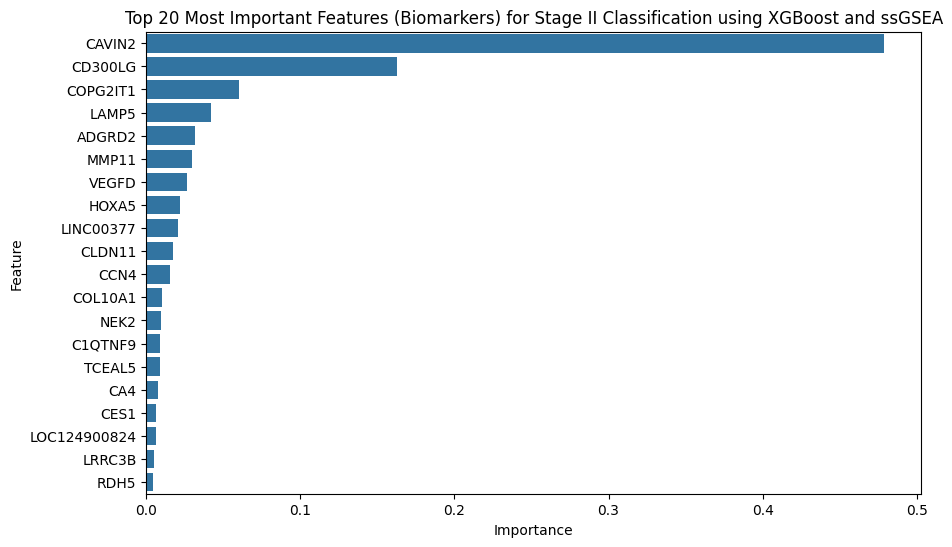

In [234]:
from xgboost import XGBClassifier

# XGBoost Classifier
xgb_2_ss = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_2_ss.fit(X_train_scaled_rf_2_ss, y_train_rf_2_ss)
y_pred_xgb_2_ss = xgb_2_ss.predict(X_test_scaled_rf_2_ss)
y_proba_xgb_2_ss = xgb_2_ss.predict_proba(X_test_scaled_rf_2_ss)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_2_ss, y_pred_xgb_2_ss))
print("ROC-AUC:", roc_auc_score(y_test_rf_2_ss, y_proba_xgb_2_ss))
print("\nClassification Report:\n", classification_report(y_test_rf_2_ss, y_pred_xgb_2_ss))

cm = confusion_matrix(y_test_rf_2_ss, y_pred_xgb_2_ss)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

feature_importances = xgb_2_ss.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_rf_2_ss.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using XGBoost and ssGSEA")
plt.show()

importance_df.to_csv("xgb_dge_ssgsea_stage2_vs_normal.csv")


#### Logistic Regression

Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       127

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



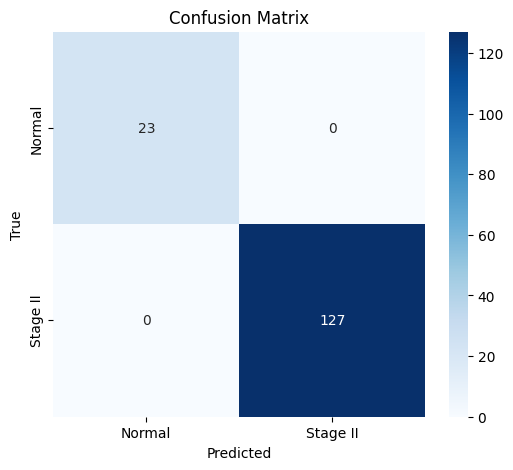

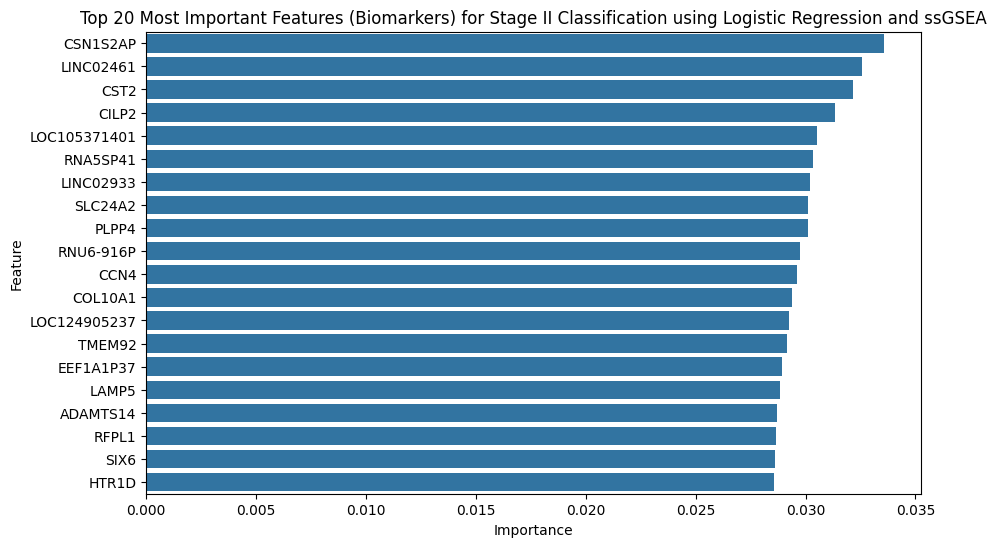

In [235]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
lr_2_ss = LogisticRegression(random_state=42, max_iter=1000)
lr_2_ss.fit(X_train_scaled_rf_2_ss, y_train_rf_2_ss)
y_pred_lr_2_ss = lr_2_ss.predict(X_test_scaled_rf_2_ss)
y_proba_lr_2_ss = lr_2_ss.predict_proba(X_test_scaled_rf_2_ss)[:, 1]

print("Accuracy:", accuracy_score(y_test_rf_2_ss, y_pred_lr_2_ss))
print("ROC-AUC:", roc_auc_score(y_test_rf_2_ss, y_proba_lr_2_ss))
print("\nClassification Report:\n", classification_report(y_test_rf_2_ss, y_pred_lr_2_ss))

cm = confusion_matrix(y_test_rf_2_ss, y_pred_lr_2_ss)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage II'], yticklabels=['Normal', 'Stage II'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Logistic Regression does not have built-in feature importance.
# Use coefficients as feature importance.
coefficients = lr_2_ss.coef_[0]
importance_df = pd.DataFrame({'Feature': X_train_rf_2_ss.columns, 'Importance': coefficients})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Most Important Features (Biomarkers) for Stage II Classification using Logistic Regression and ssGSEA")
plt.show()

importance_df.to_csv("lr_dge_ssgsea_stage2_vs_normal.csv")
